#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Наша задача - построить модель для такого предсказания.

Условием заказчика является значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Требуется:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


`num_orders` - целевой признак (количество заказов). 

## Изучение данных из файла

Загрузим и изучим данные. Выполним их ресемплирование по одному часу.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings(action='ignore')

RANDOM_STATE = 42

In [2]:
# сделаем настройку для удобства и наглядности

# снимем ограничение на количество столбцов
pd.set_option('display.max_columns', 50)

# снимем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# игнорируем предупреждения
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# выставим ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# устанавим стиль графиков
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})   
sns.set_context('notebook') 
sns.set_style('ticks') 
sns.set_style('whitegrid')
clr = '#8CA0D7'

In [3]:
# загрузим данные и сохраним их в переменную
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
# посмотрим на первые строки таблицы
data.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [5]:
# посмотрим на последние строки таблицы
data.tail()

num_orders
datetime                       
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

In [6]:
# проверим в хронологичном ли порядке расположены даты
if data.index.is_monotonic_increasing:
    print('Данные в хронологическом порядке')
else:
    print('Данные не в хронологическом порядке')

Данные в хронологическом порядке


In [7]:
# выполним ресемплирование данных по одному часу
data = data.resample('1H').sum() 
data.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

In [8]:
# посмотрим общую информацию по получившемуся датафрейму
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
# изучим детальнее числовые признаки
data.describe()

num_orders
count    4,416.00
mean        84.42
std         45.02
min          0.00
25%         54.00
50%         78.00
75%        107.00
max        462.00

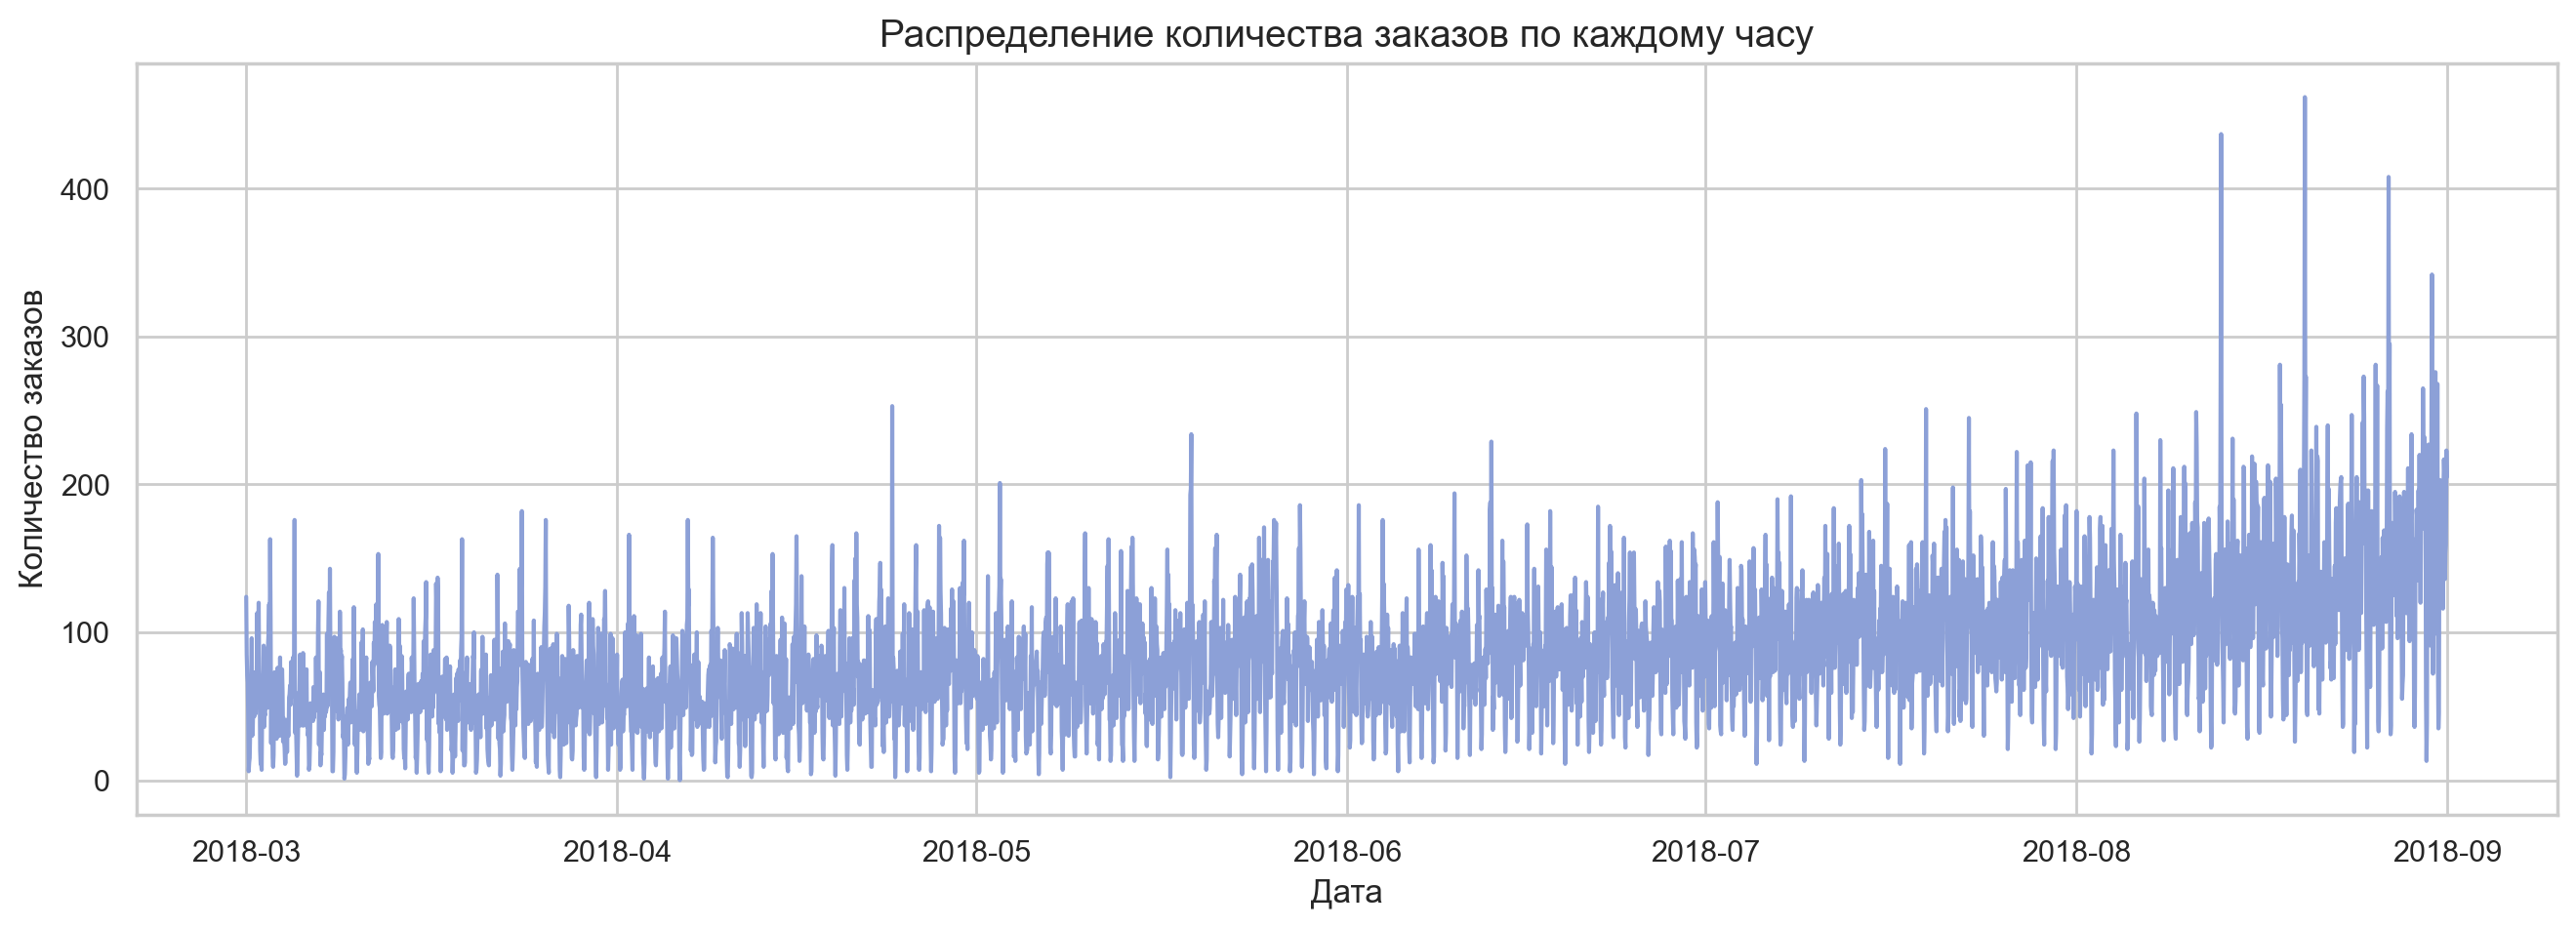

In [10]:
# построим график
plt.figure(figsize=(16, 5))
plt.title('Распределение количества заказов по каждому часу', fontsize=14)
plt.plot(data, color = clr)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.show()

### Вывод по шагу "Изучение данных из файла"

1. Перед нами данные количества заказов такси с интервалом 10 минут с 1 марта 2018 года по 31 августа 2018 года.


2. Проведено ресемплирование данных по одному часу. Получившийся датафрейм содержит 4416 строк. Целевой признак - количество заказов.


3. Перед обучением моделей данные требуется подготовить, определить, какие показатели необходимы для прогнозирования количества заказов в следующий час и добавить их в данные.

## Анализ и подготовка данных

Проанализируем данные:

1. Проведем анализ временных рядов,
2. Определим, какие показатели необходимы для обучения модели и добавим их в данные,
3. Подготовим данные для обучения моделей.

Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

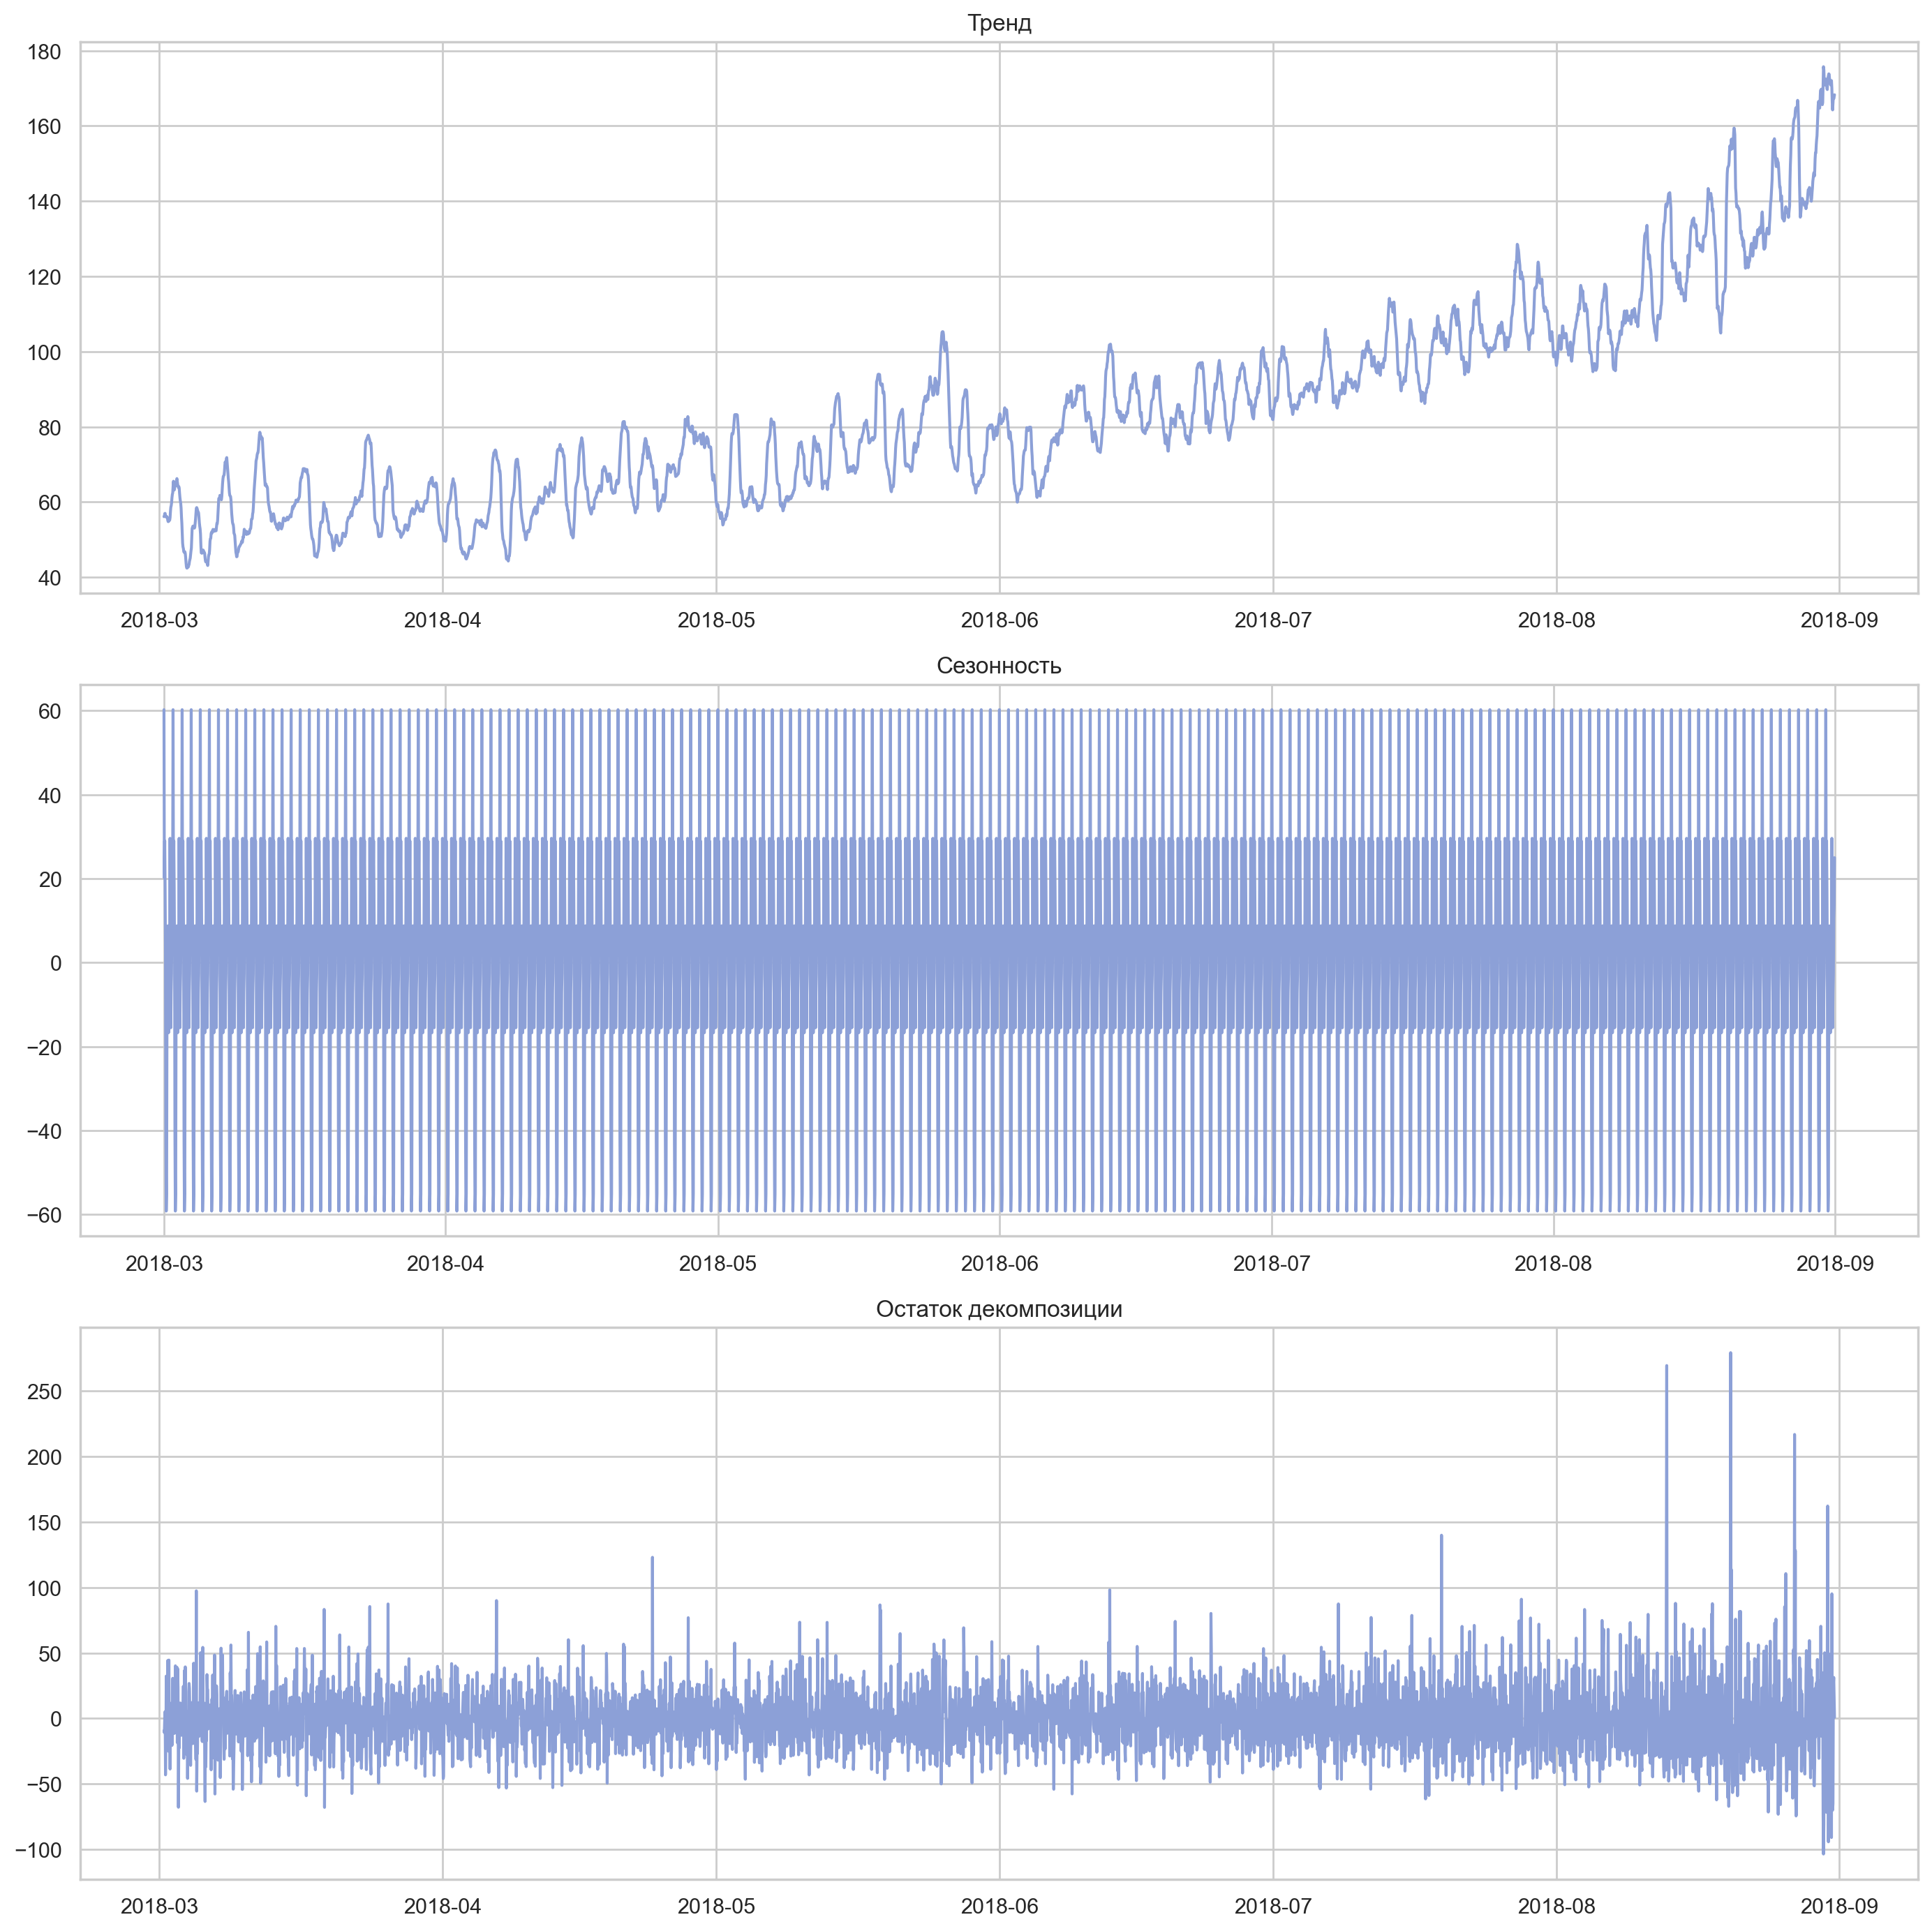

In [11]:
# разложим временной ряд на три составляющие: тренд, сезонность и остаток
decomposed_data = seasonal_decompose(data)

plt.figure(figsize=(14, 14))

plt.subplot(311)
plt.plot(decomposed_data.trend, color=clr)
plt.title('Тренд')

plt.subplot(312)
plt.plot(decomposed_data.seasonal, color=clr)
plt.title('Сезонность')

plt.subplot(313)
plt.plot(decomposed_data.resid, color=clr)
plt.title('Остаток декомпозиции')
plt.tight_layout()

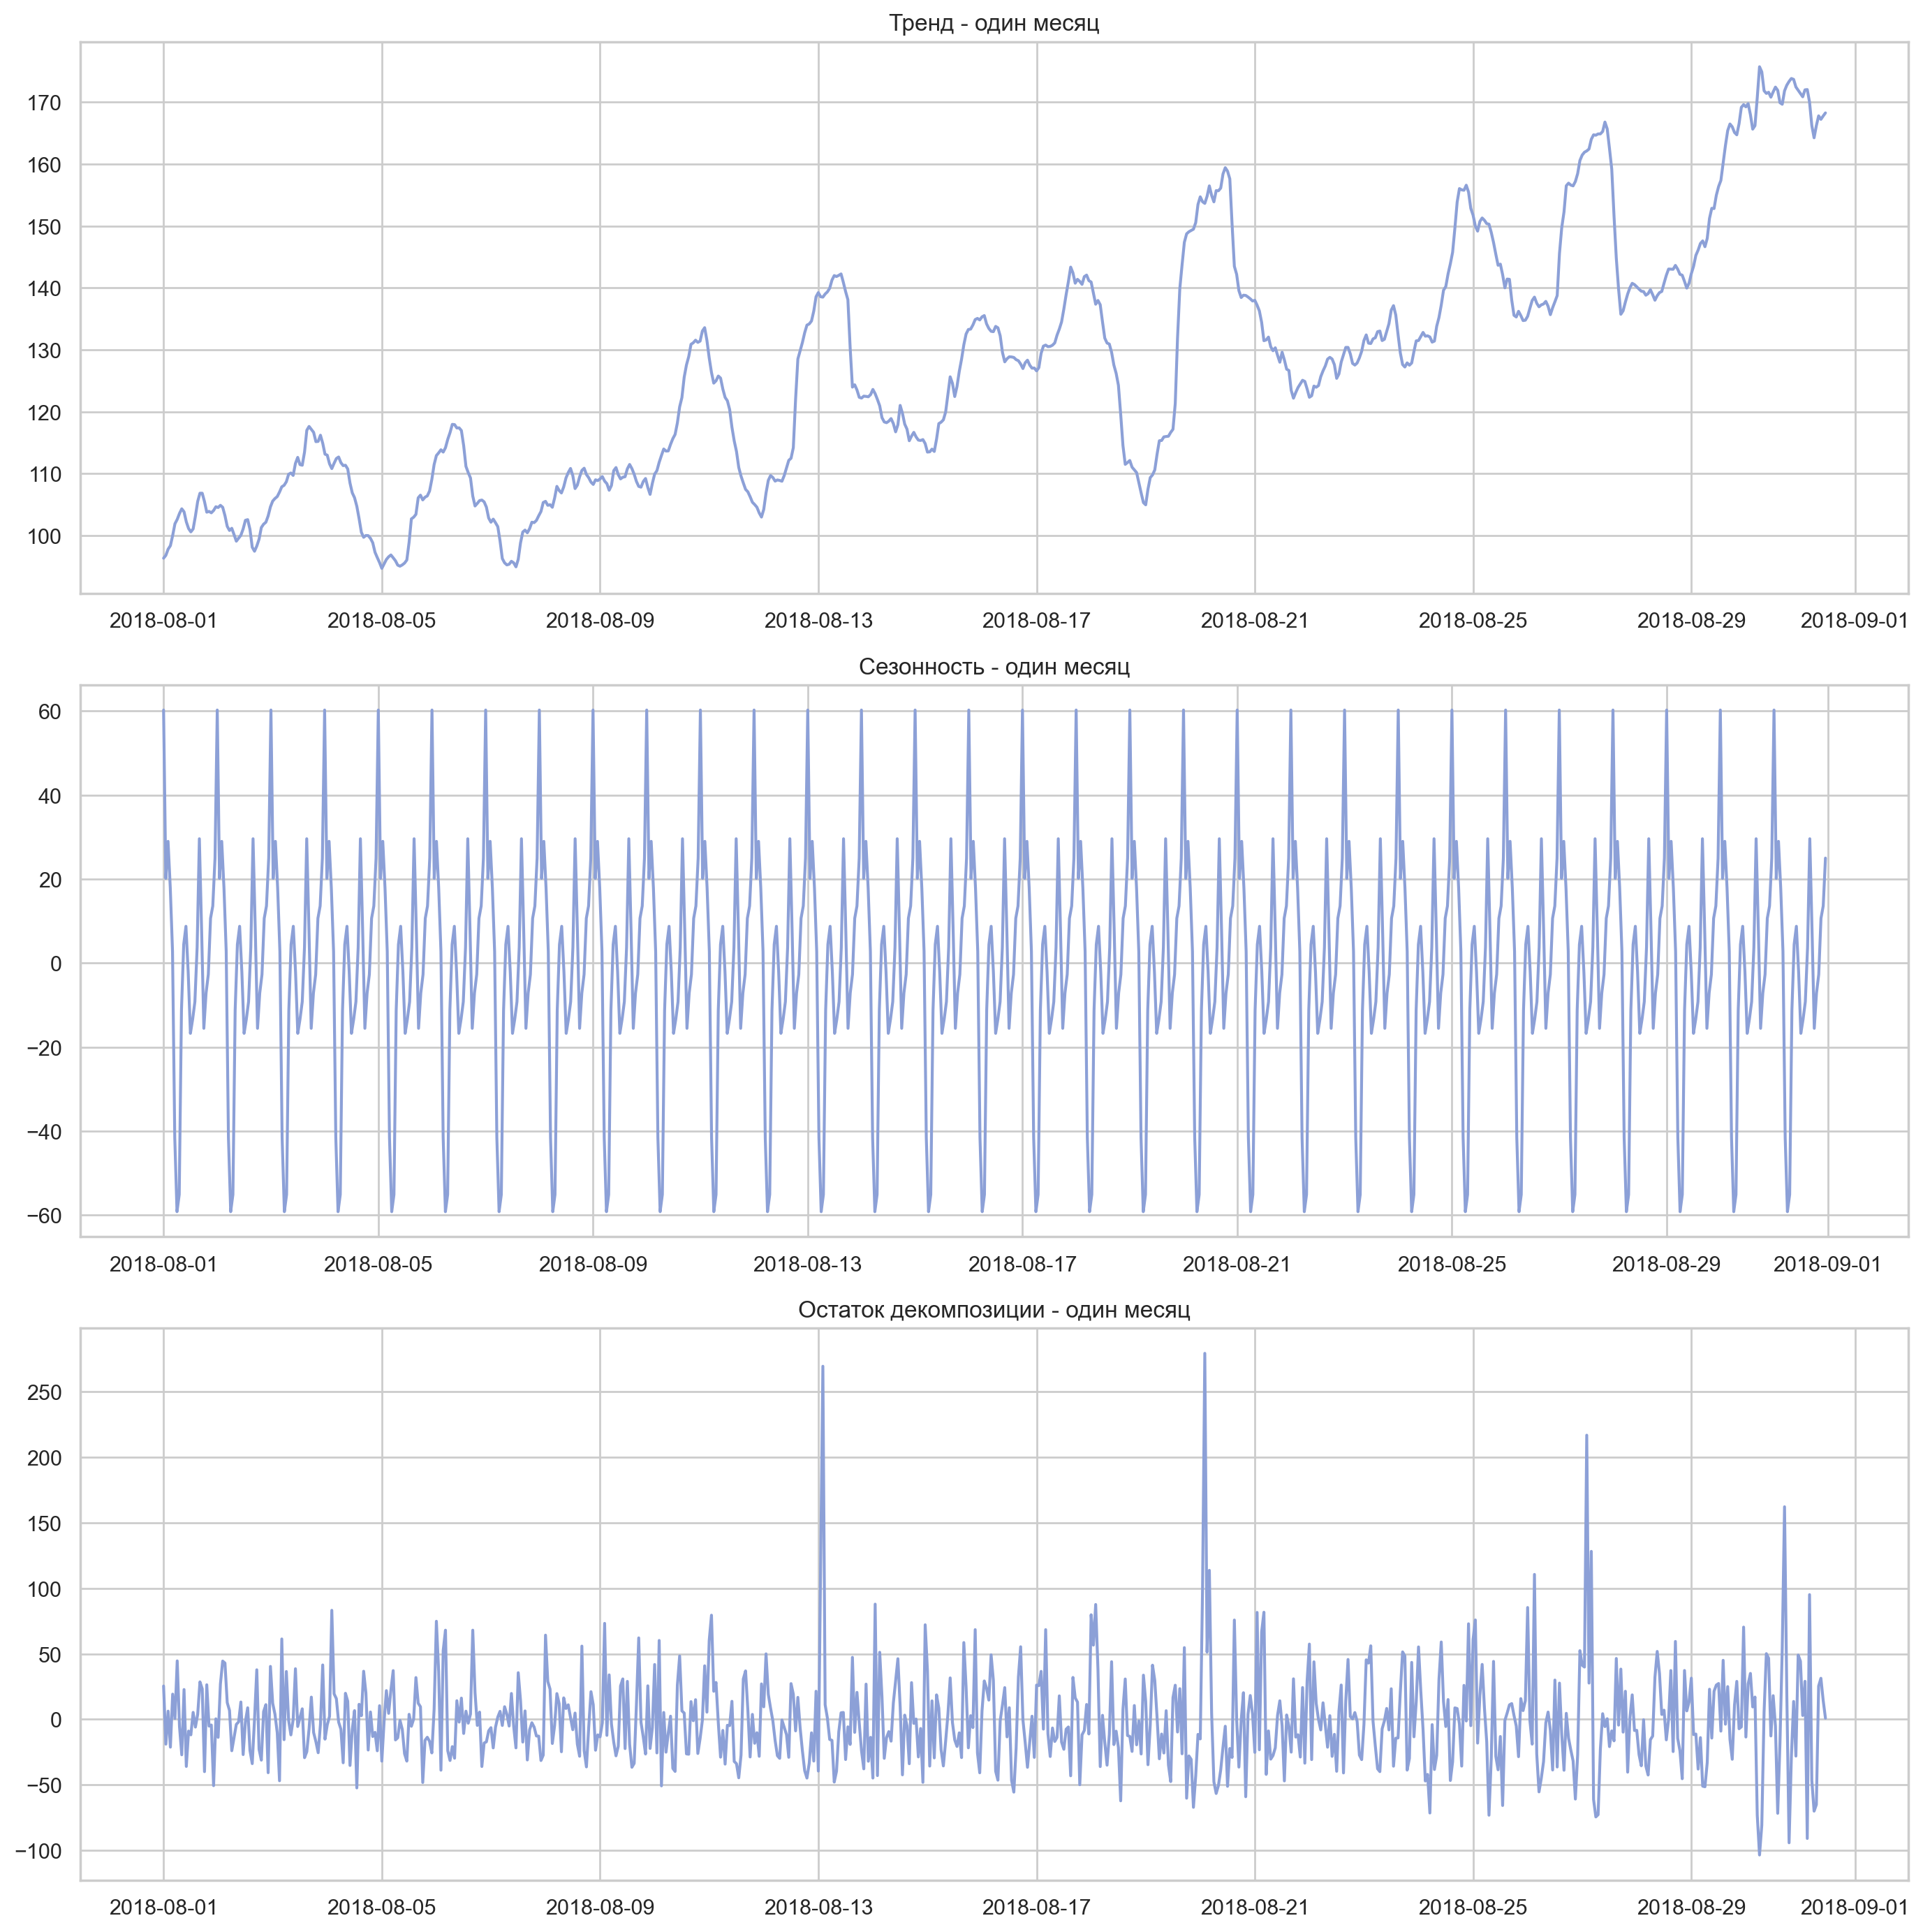

In [12]:
# уменьшим интервал до одного месяца:
plt.figure(figsize=(14, 14))

plt.subplot(311)
plt.plot(decomposed_data.trend.loc['2018-08-01':'2018-08-31'], color=clr)
plt.title('Тренд - один месяц')

plt.subplot(312)
plt.plot(decomposed_data.seasonal.loc['2018-08-01':'2018-08-31'], color=clr)
plt.title('Сезонность - один месяц')

plt.subplot(313)
plt.plot(decomposed_data.resid.loc['2018-08-01':'2018-08-31'], color=clr)
plt.title('Остаток декомпозиции - один месяц')
plt.tight_layout()

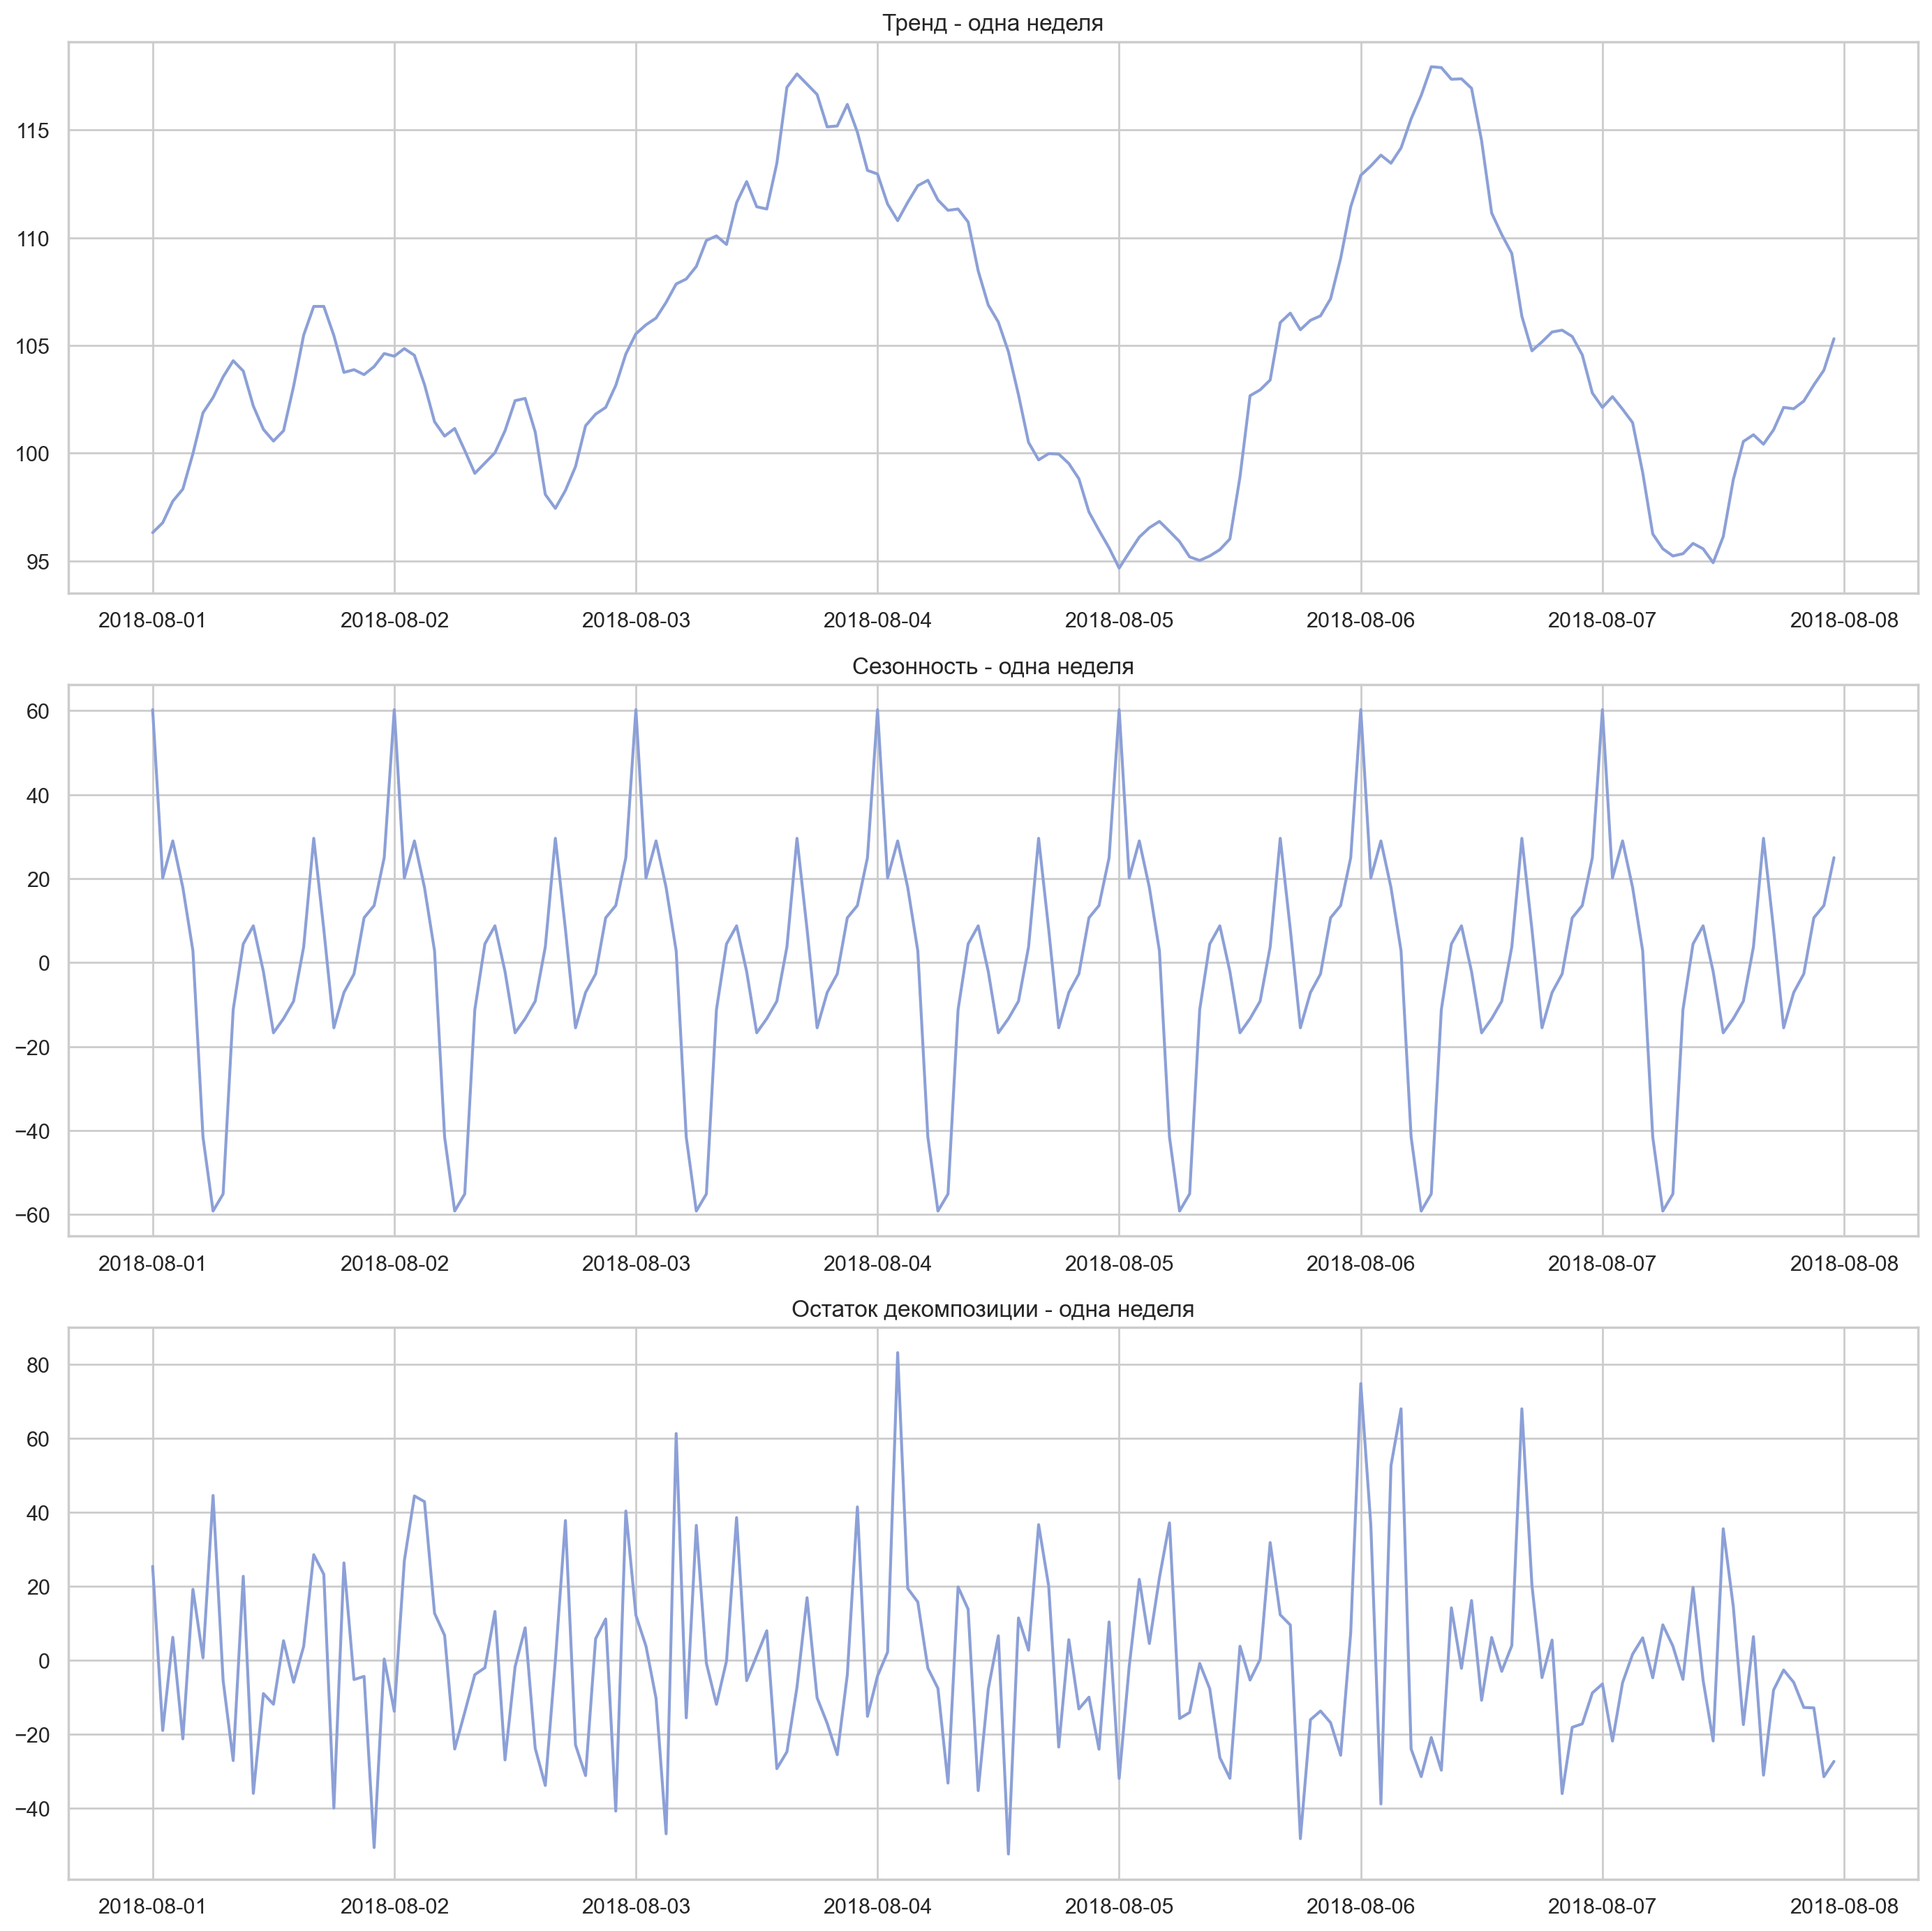

In [13]:
# уменьшим интервал до одной недели:
plt.figure(figsize=(14, 14))

plt.subplot(311)
plt.plot(decomposed_data.trend.loc['2018-08-01':'2018-08-07'], color=clr)
plt.title('Тренд - одна неделя')

plt.subplot(312)
plt.plot(decomposed_data.seasonal.loc['2018-08-01':'2018-08-07'], color=clr)
plt.title('Сезонность - одна неделя')

plt.subplot(313)
plt.plot(decomposed_data.resid.loc['2018-08-01':'2018-08-07'], color=clr)
plt.title('Остаток декомпозиции - одна неделя')
plt.tight_layout()

**Вывод:**

- На интервале одной недели видим суточную сезонность - ночью количество заказов стремится к нулю, а вечер - момент самого сильного спроса на услуги такси. В данные необходимо добавить признак "час".


- Из графика с интервалом с 1 марта 2018 года, по 31 августа 2018 года наблюдаем восходящий тренд, количество заказов и пользователей растет. В данные необходимо добавить признак "месяц" и "день".


- На интервале одной недели наблюдаем зависимость числа заказов от дня недели. Необходимо добавить данный признак в данные. 

### Добавление новых показателей

Добавим в данные новые показатели:
- месяц, день, день недели и час;
- фактор lag для определения интервала на котором обучается модель;
- скользящее среднее.

In [14]:
# напишем функцию для добавления новых показателей
# применим функцию с лагом до 24 часов и скользящим средним 48
max_lag = 24
rolling_mean_size = 48

def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour   
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

In [15]:
# применим функцию к данным
data_update = make_features(data, max_lag, rolling_mean_size)
print('Размер данных:', data_update.shape)
data_update.head()

Размер данных: (4416, 30)


num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124      3    1          3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     1 124.00    NaN   
2018-03-01 02:00:00          71      3    1          3     2  85.00 124.00   
2018-03-01 03:00:00          66      3    1          3     3  71.00  85.00   
2018-03-01 04:00:00          43      3    1          3     4  66.00  71.00   

                     lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
datetime                                                                       
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 03:00:00 124.00    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 04:00:00  85.00 124.00    NaN    NaN    NaN    NaN    NaN     NaN   

                     lag_11  lag_12  lag_13  lag_14  lag_15  lag_16  lag_17  \
datetime                                                                      
2018-03-01 00:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03-01 04:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                     lag_18  lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  \
datetime                                                                      
2018-03-01 00:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03-01 04:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                     rolling_mean  
datetime                           
2018-03-01 00:00:00           NaN  
2018-03-01 01:00:00           NaN  
2018-03-01 02:00:00           NaN  
2018-03-01 03:00:00           NaN  
2018-03-01 04:00:00           NaN

In [16]:
# удалим пропуски
data_update = data_update.dropna()
print('Размер данных:', data_update.shape)
data_update.head()

Размер данных: (4368, 30)


num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-03 00:00:00         163      3    3          5     0  72.00 119.00   
2018-03-03 01:00:00         108      3    3          5     1 163.00  72.00   
2018-03-03 02:00:00          25      3    3          5     2 108.00 163.00   
2018-03-03 03:00:00          64      3    3          5     3  25.00 108.00   
2018-03-03 04:00:00          44      3    3          5     4  64.00  25.00   

                     lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
datetime                                                                       
2018-03-03 00:00:00 101.00  93.00  49.00  89.00  83.00  82.00  59.00   44.00   
2018-03-03 01:00:00 119.00 101.00  93.00  49.00  89.00  83.00  82.00   59.00   
2018-03-03 02:00:00  72.00 119.00 101.00  93.00  49.00  89.00  83.00   82.00   
2018-03-03 03:00:00 163.00  72.00 119.00 101.00  93.00  49.00  89.00   83.00   
2018-03-03 04:00:00 108.00 163.00  72.00 119.00 101.00  93.00  49.00   89.00   

                     lag_11  lag_12  lag_13  lag_14  lag_15  lag_16  lag_17  \
datetime                                                                      
2018-03-03 00:00:00   45.00   36.00   91.00   54.00   45.00   46.00    7.00   
2018-03-03 01:00:00   44.00   45.00   36.00   91.00   54.00   45.00   46.00   
2018-03-03 02:00:00   59.00   44.00   45.00   36.00   91.00   54.00   45.00   
2018-03-03 03:00:00   82.00   59.00   44.00   45.00   36.00   91.00   54.00   
2018-03-03 04:00:00   83.00   82.00   59.00   44.00   45.00   36.00   91.00   

                     lag_18  lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  \
datetime                                                                      
2018-03-03 00:00:00   11.00   11.00   20.00   64.00   75.00  120.00   90.00   
2018-03-03 01:00:00    7.00   11.00   11.00   20.00   64.00   75.00  120.00   
2018-03-03 02:00:00   46.00    7.00   11.00   11.00   20.00   64.00   75.00   
2018-03-03 03:00:00   45.00   46.00    7.00   11.00   11.00   20.00   64.00   
2018-03-03 04:00:00   54.00   45.00   46.00    7.00   11.00   11.00   20.00   

                     rolling_mean  
datetime                           
2018-03-03 00:00:00         59.79  
2018-03-03 01:00:00         60.60  
2018-03-03 02:00:00         61.08  
2018-03-03 03:00:00         60.12  
2018-03-03 04:00:00         60.08

**Вывод:**

В таблицу добавлены следующие показатели:

- Номер месяца. Из общего тренда видим, что данный признак оказывает влияние на количество заказов;
- Номер дня. Фактор дня оказывает влияние, так как в интервале месяца наблюдаем восходящий тренд роста числа заказов;
- День недели. В интервале недели наблюдаем влияние дня недели на количество заказов;
- Номер часа. Фактор часа играет самую важную роль, так как прогнозирование числа заказов такси происходит на ближайший час. Здесь же наблюдается сезонность, где есть важные часы максимумов и минимумов;
- Фактор lag. Нужен для определения интервала на котором обучается модель;
- Скользящее среднее.

### Подготовка данных к обучению моделей

Разделим данные на обучающую и тестовую выборку в отношении 9:1.

In [17]:
# разделим данные и целевой признак
features = data_update.drop(['num_orders'], axis=1)
target = data_update['num_orders']
print('Размер получившихся данных:', features.shape)
print('Целевой признак:', target.shape)
features.head()

Размер получившихся данных: (4368, 29)
Целевой признак: (4368,)


month  day  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-03 00:00:00      3    3          5     0  72.00 119.00 101.00  93.00   
2018-03-03 01:00:00      3    3          5     1 163.00  72.00 119.00 101.00   
2018-03-03 02:00:00      3    3          5     2 108.00 163.00  72.00 119.00   
2018-03-03 03:00:00      3    3          5     3  25.00 108.00 163.00  72.00   
2018-03-03 04:00:00      3    3          5     4  64.00  25.00 108.00 163.00   

                     lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  \
datetime                                                                 
2018-03-03 00:00:00  49.00  89.00  83.00  82.00  59.00   44.00   45.00   
2018-03-03 01:00:00  93.00  49.00  89.00  83.00  82.00   59.00   44.00   
2018-03-03 02:00:00 101.00  93.00  49.00  89.00  83.00   82.00   59.00   
2018-03-03 03:00:00 119.00 101.00  93.00  49.00  89.00   83.00   82.00   
2018-03-03 04:00:00  72.00 119.00 101.00  93.00  49.00   89.00   83.00   

                     lag_12  lag_13  lag_14  lag_15  lag_16  lag_17  lag_18  \
datetime                                                                      
2018-03-03 00:00:00   36.00   91.00   54.00   45.00   46.00    7.00   11.00   
2018-03-03 01:00:00   45.00   36.00   91.00   54.00   45.00   46.00    7.00   
2018-03-03 02:00:00   44.00   45.00   36.00   91.00   54.00   45.00   46.00   
2018-03-03 03:00:00   59.00   44.00   45.00   36.00   91.00   54.00   45.00   
2018-03-03 04:00:00   82.00   59.00   44.00   45.00   36.00   91.00   54.00   

                     lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  \
datetime                                                              
2018-03-03 00:00:00   11.00   20.00   64.00   75.00  120.00   90.00   
2018-03-03 01:00:00   11.00   11.00   20.00   64.00   75.00  120.00   
2018-03-03 02:00:00    7.00   11.00   11.00   20.00   64.00   75.00   
2018-03-03 03:00:00   46.00    7.00   11.00   11.00   20.00   64.00   
2018-03-03 04:00:00   45.00   46.00    7.00   11.00   11.00   20.00   

                     rolling_mean  
datetime                           
2018-03-03 00:00:00         59.79  
2018-03-03 01:00:00         60.60  
2018-03-03 02:00:00         61.08  
2018-03-03 03:00:00         60.12  
2018-03-03 04:00:00         60.08

In [18]:
# разделим данные на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    shuffle=False, 
    test_size=0.1, 
    random_state=RANDOM_STATE)
    
print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)
print('Размер целевого признака для обучающей выборки:', target_train.shape)
print('Размер целевого признака для тестовой выборки:', target_test.shape)
features_train.head()

Размер обучающей выборки: (3931, 29)
Размер тестовой выборки: (437, 29)
Размер целевого признака для обучающей выборки: (3931,)
Размер целевого признака для тестовой выборки: (437,)


month  day  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-03 00:00:00      3    3          5     0  72.00 119.00 101.00  93.00   
2018-03-03 01:00:00      3    3          5     1 163.00  72.00 119.00 101.00   
2018-03-03 02:00:00      3    3          5     2 108.00 163.00  72.00 119.00   
2018-03-03 03:00:00      3    3          5     3  25.00 108.00 163.00  72.00   
2018-03-03 04:00:00      3    3          5     4  64.00  25.00 108.00 163.00   

                     lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  \
datetime                                                                 
2018-03-03 00:00:00  49.00  89.00  83.00  82.00  59.00   44.00   45.00   
2018-03-03 01:00:00  93.00  49.00  89.00  83.00  82.00   59.00   44.00   
2018-03-03 02:00:00 101.00  93.00  49.00  89.00  83.00   82.00   59.00   
2018-03-03 03:00:00 119.00 101.00  93.00  49.00  89.00   83.00   82.00   
2018-03-03 04:00:00  72.00 119.00 101.00  93.00  49.00   89.00   83.00   

                     lag_12  lag_13  lag_14  lag_15  lag_16  lag_17  lag_18  \
datetime                                                                      
2018-03-03 00:00:00   36.00   91.00   54.00   45.00   46.00    7.00   11.00   
2018-03-03 01:00:00   45.00   36.00   91.00   54.00   45.00   46.00    7.00   
2018-03-03 02:00:00   44.00   45.00   36.00   91.00   54.00   45.00   46.00   
2018-03-03 03:00:00   59.00   44.00   45.00   36.00   91.00   54.00   45.00   
2018-03-03 04:00:00   82.00   59.00   44.00   45.00   36.00   91.00   54.00   

                     lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  \
datetime                                                              
2018-03-03 00:00:00   11.00   20.00   64.00   75.00  120.00   90.00   
2018-03-03 01:00:00   11.00   11.00   20.00   64.00   75.00  120.00   
2018-03-03 02:00:00    7.00   11.00   11.00   20.00   64.00   75.00   
2018-03-03 03:00:00   46.00    7.00   11.00   11.00   20.00   64.00   
2018-03-03 04:00:00   45.00   46.00    7.00   11.00   11.00   20.00   

                     rolling_mean  
datetime                           
2018-03-03 00:00:00         59.79  
2018-03-03 01:00:00         60.60  
2018-03-03 02:00:00         61.08  
2018-03-03 03:00:00         60.12  
2018-03-03 04:00:00         60.08

**Вывод:**

- Данные были разделены на обучающую и тестовую выборку в отношении 9:1.

### Вывод "Анализ данных"

1. Во временном ряде видна суточная сезонность. Ночью количество заказов стремится к нулю, а вечер - момент самого сильного спроса на услуги такси.


2. Из графиков наблюдаем восходящий тренд, количество заказов и пользователей растет. Временной ряд не является стационарным, так как подвержен тренду, который меняется во времени.


3. Для обучения моделей в данные добавлены новые показатели: месяц, день, день недели, час, фактор lag для определения интервала на котором обучается модель и скользящее среднее.


4. Данные были разделены на обучающую и тестовую выборку в отношении 9:1.

## Обучение моделей

Для обучения будем использовать следующие модели:

1. Линейная регрессия / Linear Regression
2. Случайный лес /  Random Forest Regressor
3. Градиентный бустинг / Cat Boost Regressor
4. Стохастический градиентный бустинг / Light GBM

In [19]:
# создадим функцию для построения графика распределения предсказанных и истинных значений
def plot_true_predict (target_test, predictions, color1, color2):
    plt.figure(figsize=(16, 6))
    plt.plot(target_test.index, target_test, label='Истинные значения', color=color2, alpha=0.9)
    plt.plot(target_test.index, predictions, label='Предсказанные значения', color=color1, alpha=0.9)
    plt.title('График распределения предсказанных и истинных значений', y=1.05, fontsize=15)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Количество заказов такси', fontsize=12)
    plt.legend()
    plt.show()

### Линейная регрессия / Linear Regression

- Обучим модель и оценим ее качество с помощью кроссвалидации, используя метрику RMSE,
- Для разделения временных рядов на обучающую и тестовую выборки будем использовать TimeSeriesSplit,
- Построим график распределения предсказанных и истинных значений.

In [20]:
# переберем различные гиперпараметры Linear Regression с помощью GridSearch CV. Найдем лучшие
tss_cv = TimeSeriesSplit(n_splits=5)
model_lr = LinearRegression()

linreg_params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
}

gs_linreg = GridSearchCV (
    model_lr, 
    linreg_params, 
    scoring='neg_root_mean_squared_error', 
    cv=tss_cv,
    n_jobs=-1
)

gs_linreg.fit(features_train, target_train)
rmse_lr = gs_linreg.best_score_ * (-1)
best_model_lr = gs_linreg.best_estimator_

print(f'Лучшее значение RMSE: {round(rmse_lr, 1)}')
print(f'Лучшие параметры: {gs_linreg.best_params_}')

Лучшее значение RMSE: 27.0
Лучшие параметры: {'copy_X': True, 'fit_intercept': False}


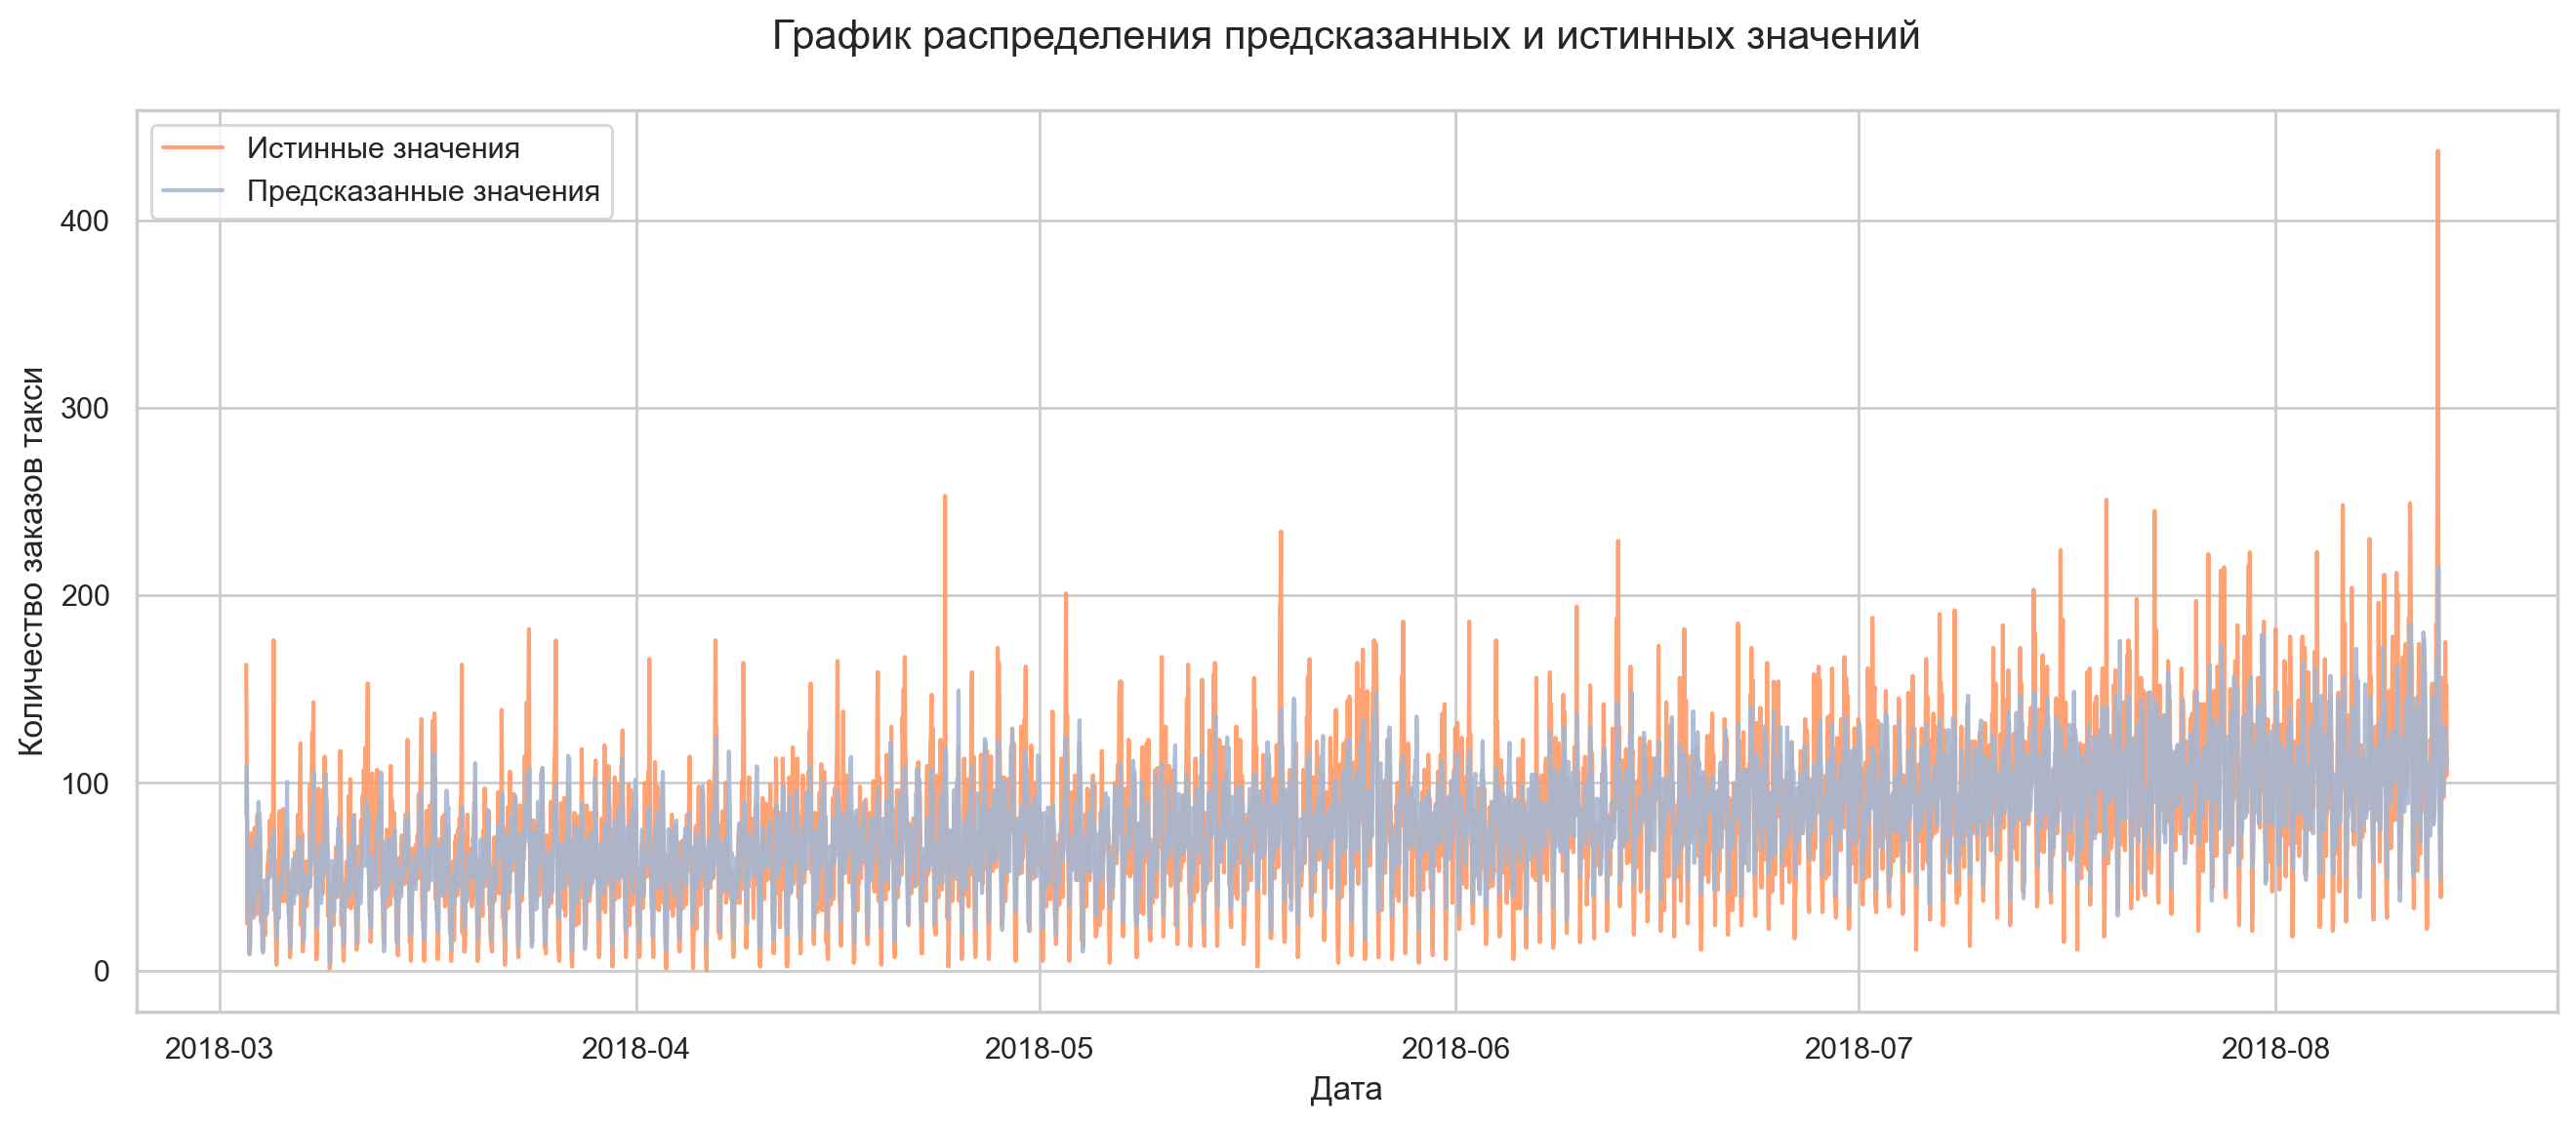

In [21]:
# построим график
plot_true_predict(target_train, best_model_lr.predict(features_train), '#A5B7D2', '#FF9966')

**Вывод:**

- Средний показатель RMSE линейной регрессии = 27. 

### Случайный лес / Random Forest Regressor

- Обучим модель и оценим ее качество с помощью кроссвалидации, используя метрику RMSE
- Для разделения временных рядов на обучающую и тестовую выборки будем использовать TimeSeriesSplit
- Построим график распределения предсказанных и истинных значений

In [22]:
# переберем различные гиперпараметры  Random Forest Regressor с помощью GridSearch CV. Найдем лучшие
tss_cv = TimeSeriesSplit(n_splits=5)

model_forest = RandomForestRegressor(random_state=RANDOM_STATE)

forest_params = {
    'max_depth': range(2, 10, 2),  
    'n_estimators': range(10, 300, 50),
    'min_samples_leaf': range(1,5),
    'min_samples_split': range(2,8,2)
}

gs_forest = GridSearchCV (
    model_forest, 
    forest_params, 
    scoring='neg_root_mean_squared_error', 
    cv=tss_cv,
    n_jobs=-1
)

gs_forest.fit(features_train, target_train)
rmse_rfr = gs_forest.best_score_ * (-1)
best_model_rfr = gs_forest.best_estimator_

print(f'Лучшее значение RMSE: {round(rmse_rfr, 1)}')
print(f'Лучшие параметры: {gs_forest.best_params_}')

Лучшее значение RMSE: 25.8
Лучшие параметры: {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 260}


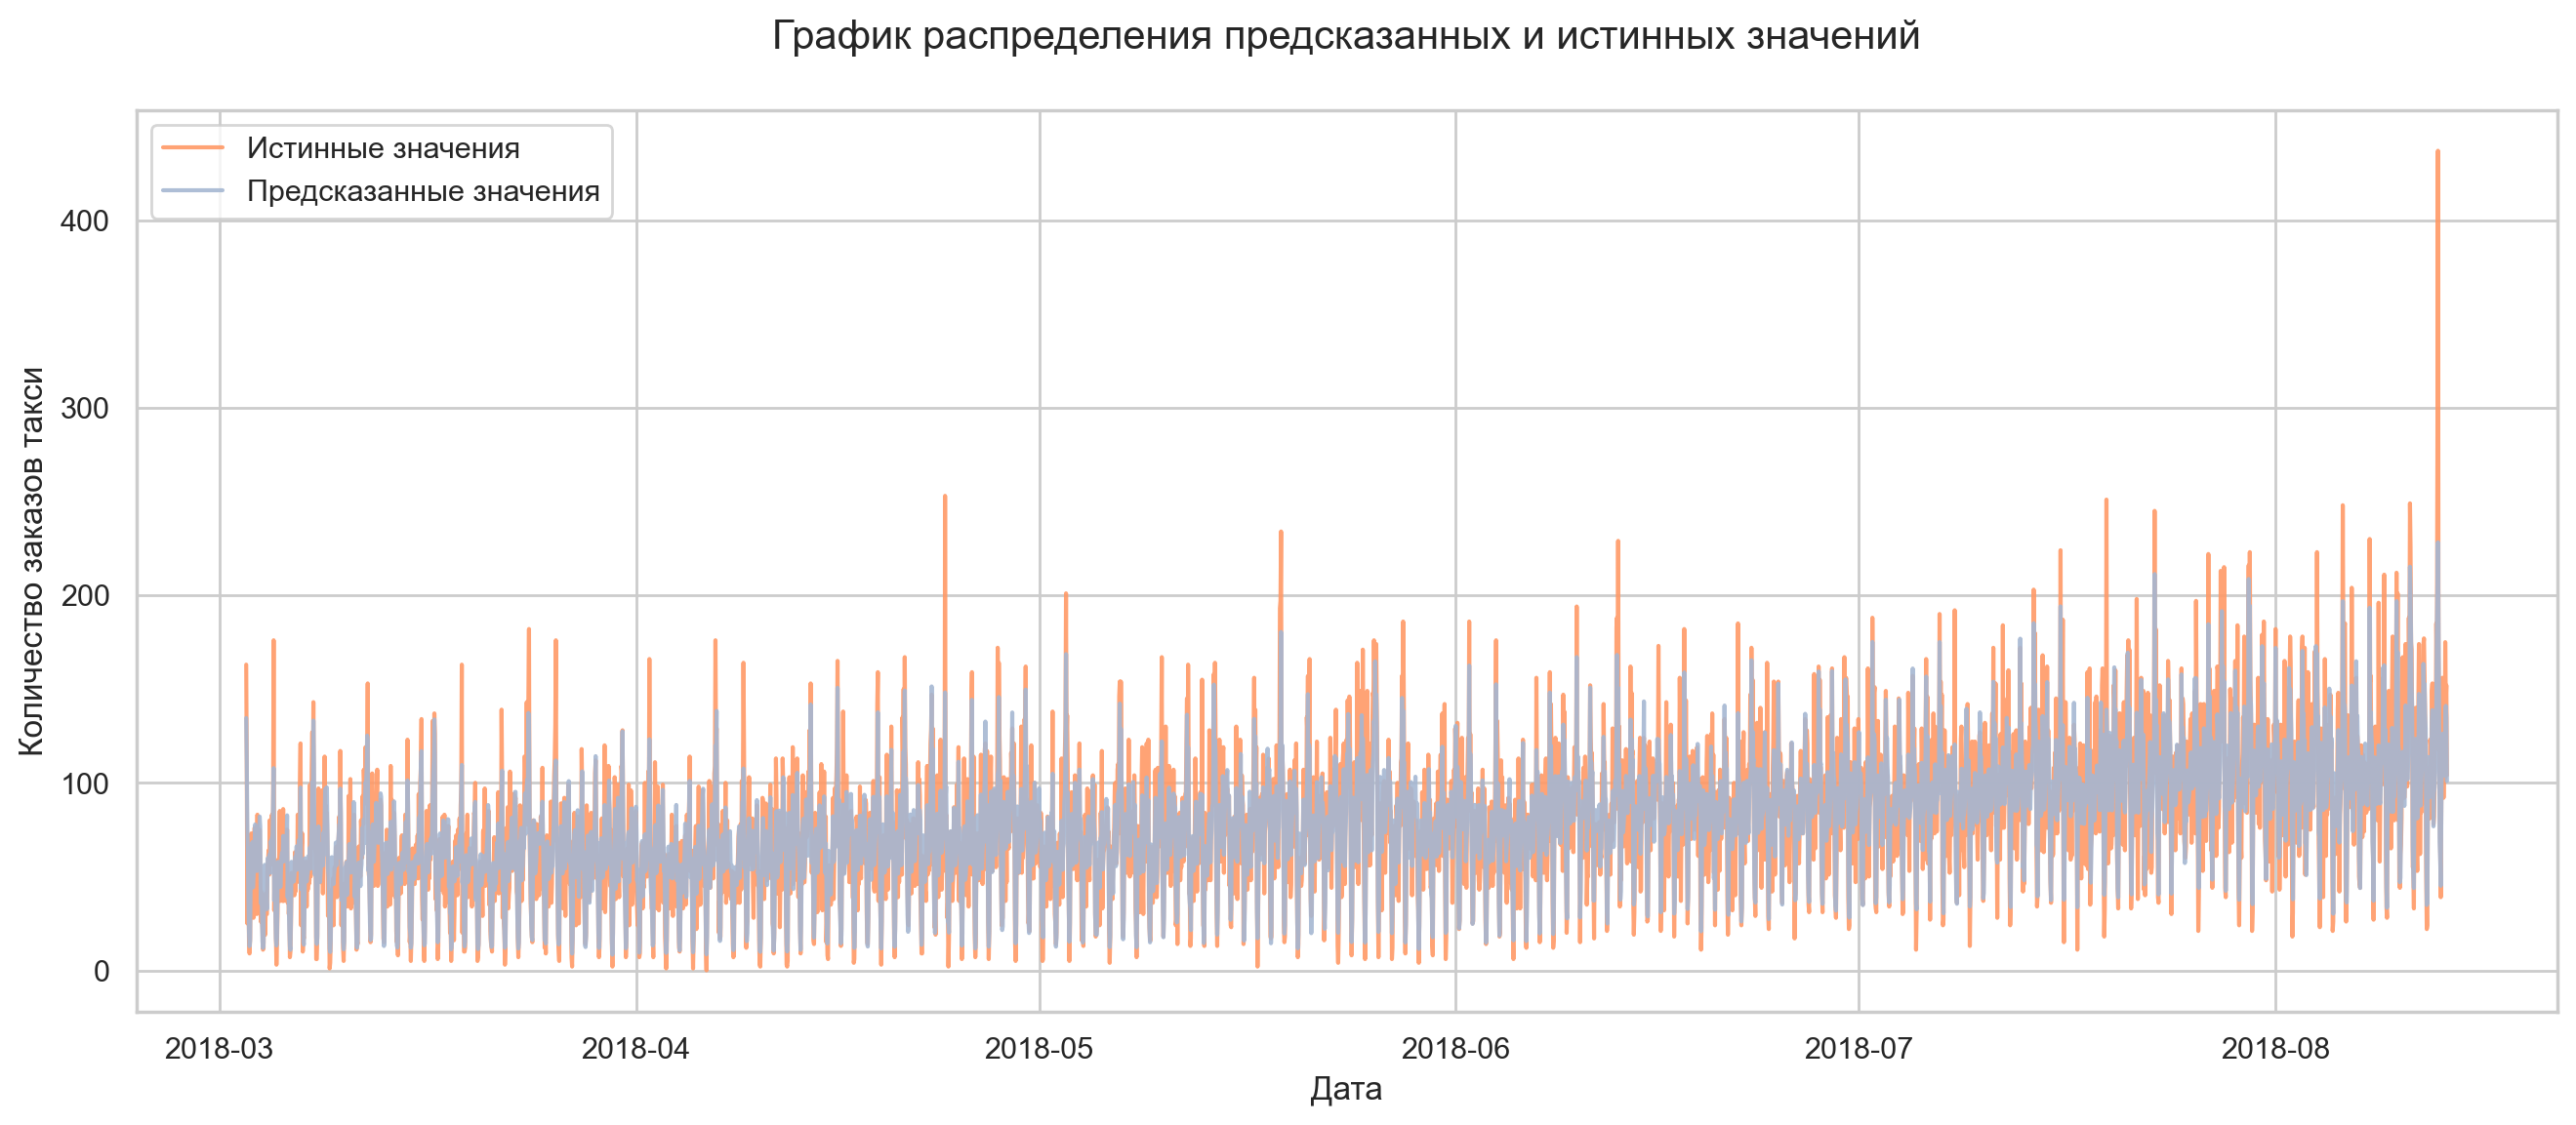

In [23]:
# построим график
plot_true_predict(target_train, best_model_rfr.predict(features_train), '#A5B7D2', '#FF9966')

**Вывод:**

Средний показатель RMSE случайного леса = 25,8. Наилучшее качество модели достигатся при параметрах:
- количество деревьев = 260,
- максимальная глубина дерева = 8,
- минимальное число объектов в листьях = 3,
- минимальное число объектов, при котором выполняется расщепление = 2.

### Градиентный бустинг / Cat Boost Regressor

- Обучим модель и оценим ее качество с помощью кроссвалидации, используя метрику RMSE
- Для разделения временных рядов на обучающую и тестовую выборки будем использовать TimeSeriesSplit
- Построим график распределения предсказанных и истинных значений

In [24]:
# переберем различные гиперпараметры  Cat Boost Classifier с помощью GridSearch CV. Найдем лучшие
tss_cv = TimeSeriesSplit(n_splits=5)

model_catboost = CatBoostRegressor(random_state=RANDOM_STATE)

catboost_params = {
    'learning_rate': [.1, .01, .3], 
    'depth': [i for i in range(2, 7)],
    'iterations': [500, 1000, 1500, 2000],
    'verbose':[False],
}

gs_catboost = GridSearchCV (
    model_catboost, 
    catboost_params, 
    scoring='neg_root_mean_squared_error', 
    cv=tss_cv,
    n_jobs=-1
)

gs_catboost.fit(features_train, target_train)
rmse_cbr = gs_catboost.best_score_ * (-1)
best_model_cbr = gs_catboost.best_estimator_

print(f'Лучшее значение RMSE: {round(rmse_cbr, 1)}')
print(f'Лучшие параметры: {gs_catboost.best_params_}')

Лучшее значение RMSE: 24.3
Лучшие параметры: {'depth': 6, 'iterations': 2000, 'learning_rate': 0.01, 'verbose': False}


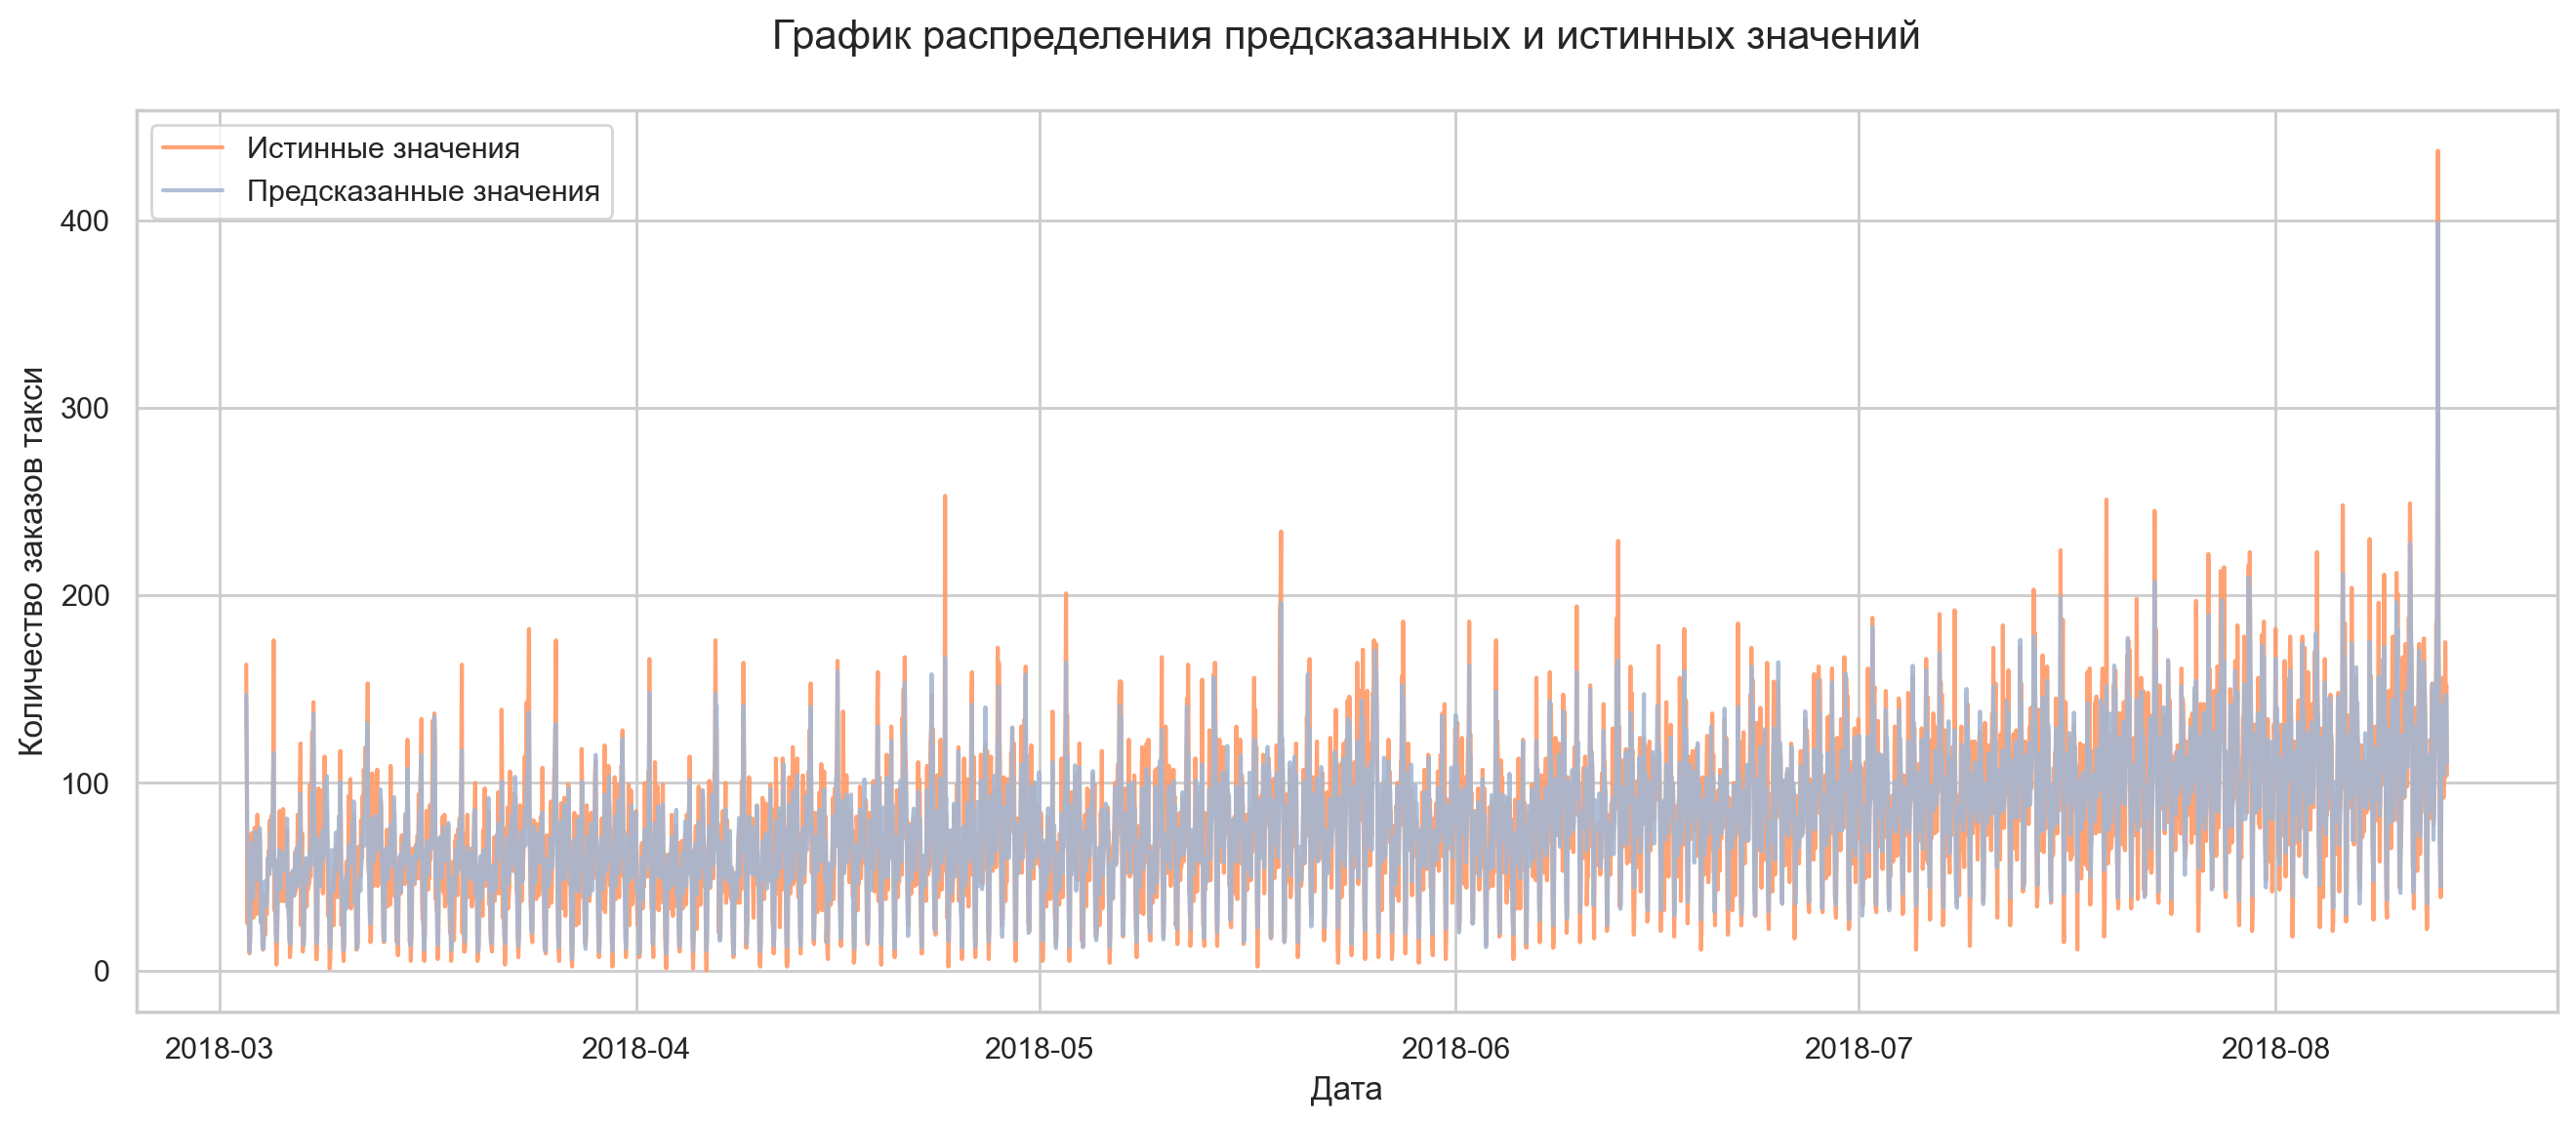

In [25]:
# построим график
plot_true_predict(target_train, best_model_cbr.predict(features_train), '#A5B7D2', '#FF9966')

**Вывод:**

Средний показатель RMSE модели градиентного бустинга = 24,3. Наилучшее качество модели достигатся при параметрах:
- количество итераций = 2000,
- максимальная глубина дерева = 6,
- скорость обучения = 0.01.

### Стохастический градиентный бустинг / Light GBM

- Обучим модель и оценим ее качество с помощью кроссвалидации, используя метрику RMSE
- Для разделения временных рядов на обучающую и тестовую выборки будем использовать TimeSeriesSplit
- Построим график распределения предсказанных и истинных значений

In [26]:
# переберем различные гиперпараметры  LGBM Classifier с помощью GridSearch CV. Найдем лучшие
tss_cv = TimeSeriesSplit(n_splits=5)

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

lgbm_params = {
    'learning_rate': [.1, .01, .3], 
    'max_depth': [None] + [i for i in range(2, 7)],
    'n_estimators': range(10, 500, 50),
}

gs_lgbm = GridSearchCV (
    model_lgbm, 
    lgbm_params, 
    scoring='neg_root_mean_squared_error', 
    cv=tss_cv,
    n_jobs=-1
)

gs_lgbm.fit(features_train, target_train)
rmse_lgbm = gs_lgbm.best_score_ * (-1)
best_model_lgbm = gs_lgbm.best_estimator_

print(f'Лучшее значение RMSE: {round(rmse_lgbm, 1)}')
print(f'Лучшие параметры: {gs_lgbm.best_params_}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4880
[LightGBM] [Info] Number of data points in the train set: 3931, number of used features: 29
[LightGBM] [Info] Start training from score 78.589163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

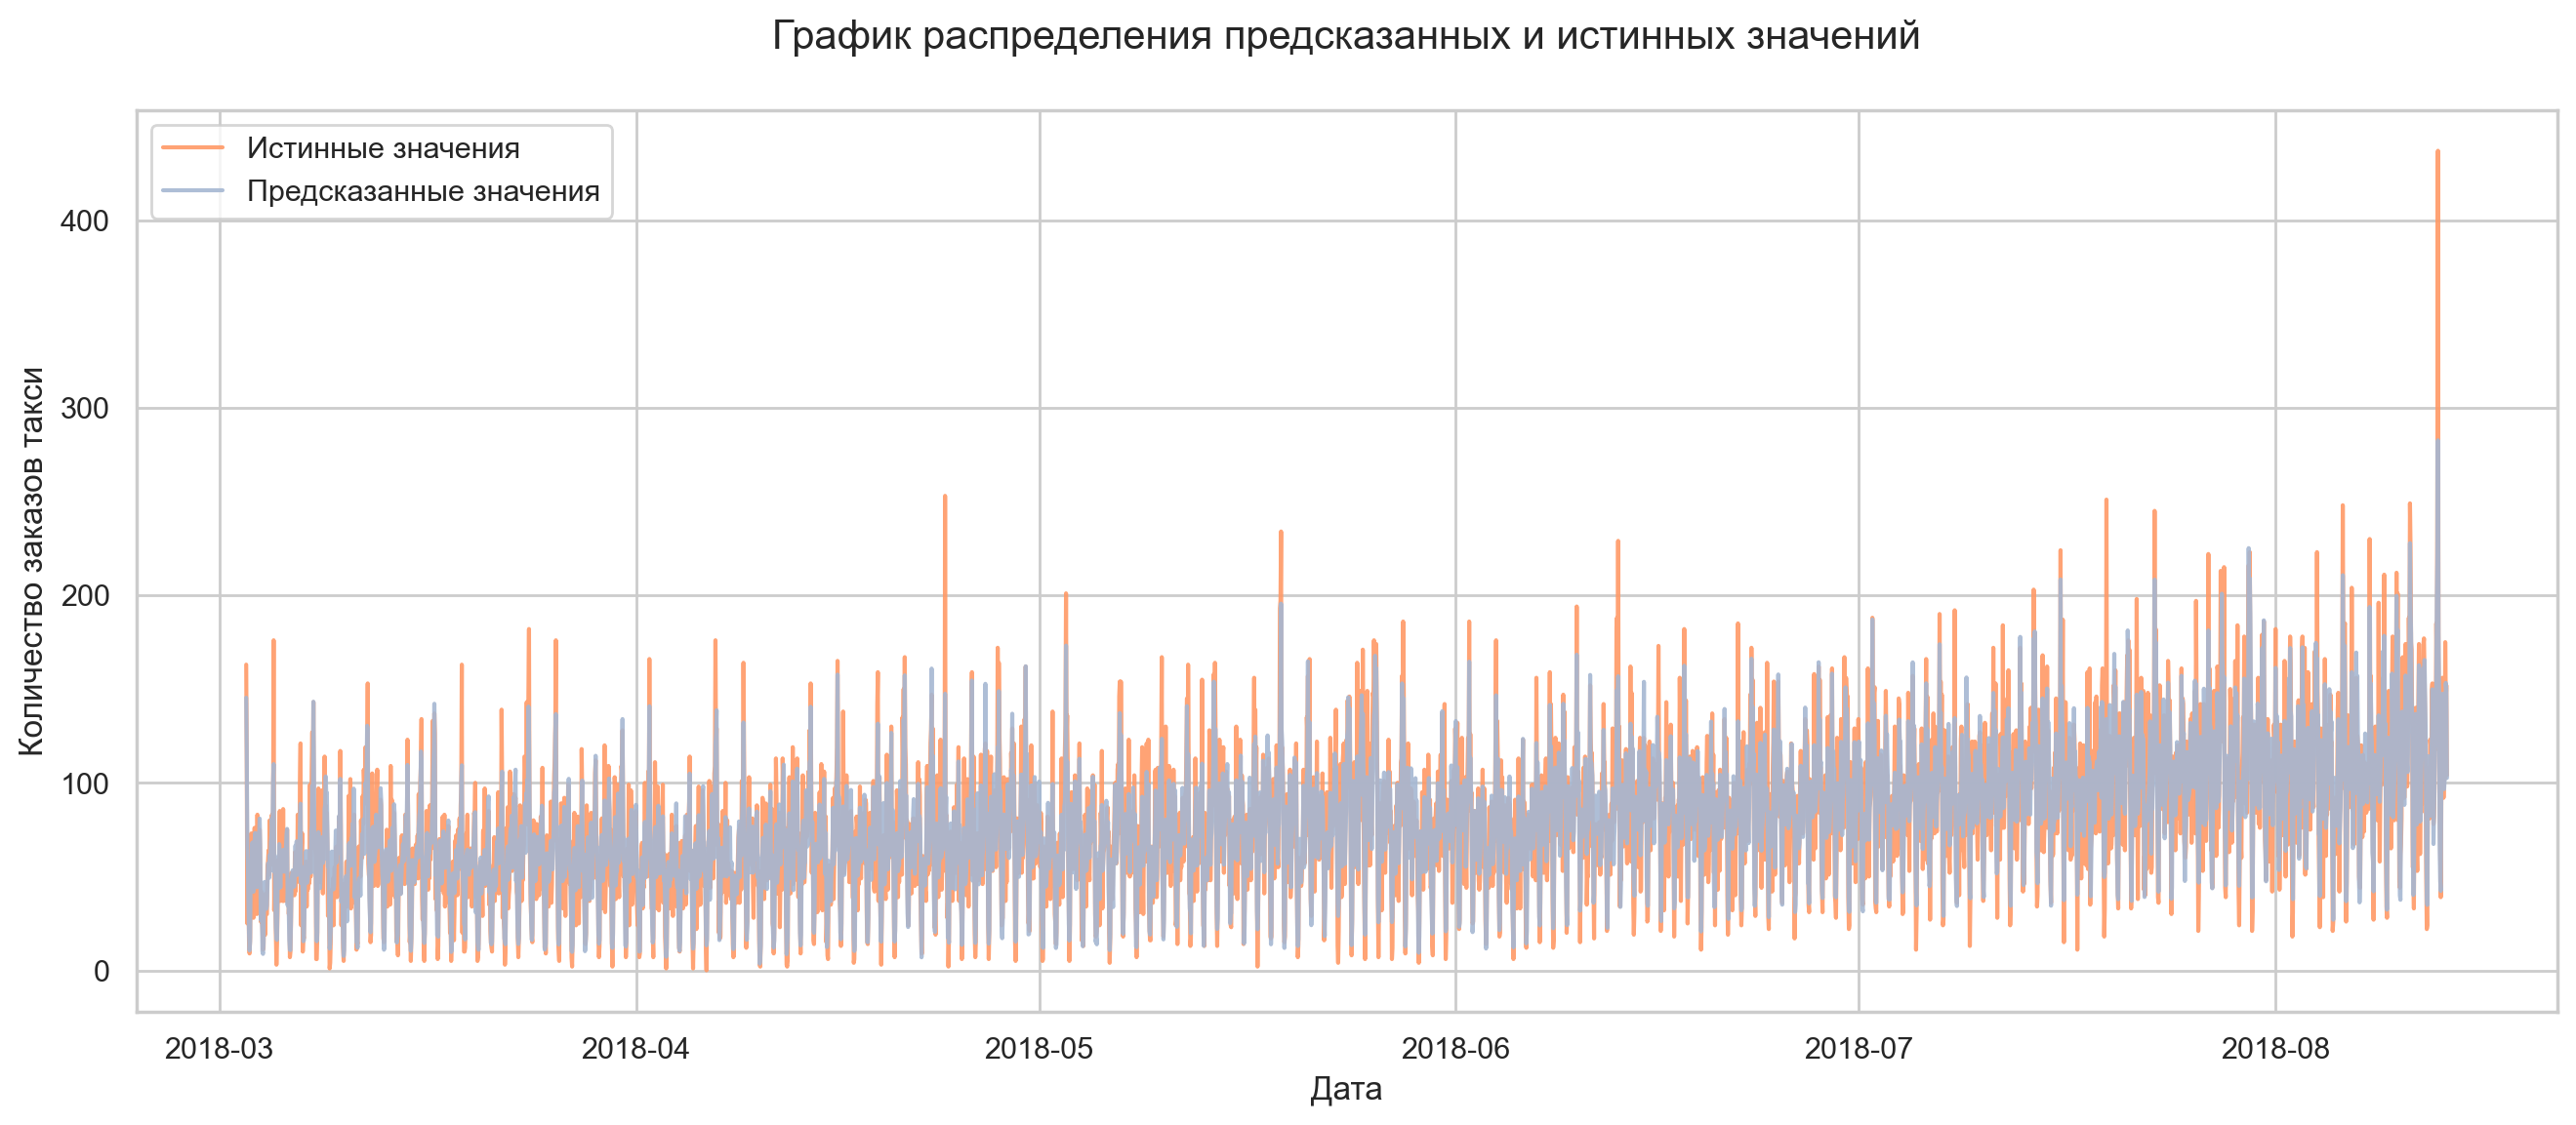

In [27]:
# построим график
plot_true_predict(target_train, best_model_lgbm.predict(features_train), '#A5B7D2', '#FF9966')

**Вывод:**

Средний показатель RMSE модели стохастического градиентного бустинга = 24,8. Наилучшее качество модели достигатся при параметрах:
- максимальное глубина дерева = 4,
- количество деревьев = 110,
- скорость обучения = 0.1.

### Анализ моделей

Определим, какую модель будем использовать для дальнейшего тестирования.

In [28]:
# создадим таблицу с показателями RMSE всех обученных моделей
index = ['Linear Regression',
         'Random Forest Regressor',
         'Cat Boost Regressor',
         'Light GBM']

metrics = {'RMSE':[round(rmse_lr, 1),
                round(rmse_rfr, 1),
                round(rmse_cbr, 1),
                round(rmse_lgbm, 1)]}

metrics_data = pd.DataFrame(data=metrics, index=index)
metrics_data.sort_values(by='RMSE')

RMSE
Cat Boost Regressor     24.30
Light GBM               24.80
Random Forest Regressor 25.80
Linear Regression       27.00

**Вывод:**

- Наилучший результат показала модель Cat Boost Regressor (RMSE = 24,3).

### Вывод "Обучение моделей"

1. На этом шаге обучили четыре модели: Линейная регрессия (Linear Regression), Случайный лес (Random Forest Regressor), Градиентный бустинг (Cat Boost Regressor), Стохастический градиентный бустинг (Light GBM).


2. Наилучший результат показала модель градиентного бустинга (средний показатель RMSE = 24,3) с количеством итераций 2000, максимальной глубиной дерева 6 и скоростью обучения 0.01. Проверим модель на тестовых данных.

## Тестирование лучшей модели

Проверим данные на тестовой выборке и сделаем выводы.

### Проверка данных на тестовой выборке 

In [29]:
# обучим модель градиентного бустинга и рассчитаем RMSE на тестовой выборке
model = CatBoostRegressor(
    iterations=2000, 
    learning_rate=0.01, 
    depth=6,
    verbose=False,
    random_state=RANDOM_STATE)

model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
print(f'RMSE модели на тестовой выборке: {round(rmse, 1)}')

RMSE модели на тестовой выборке: 41.1


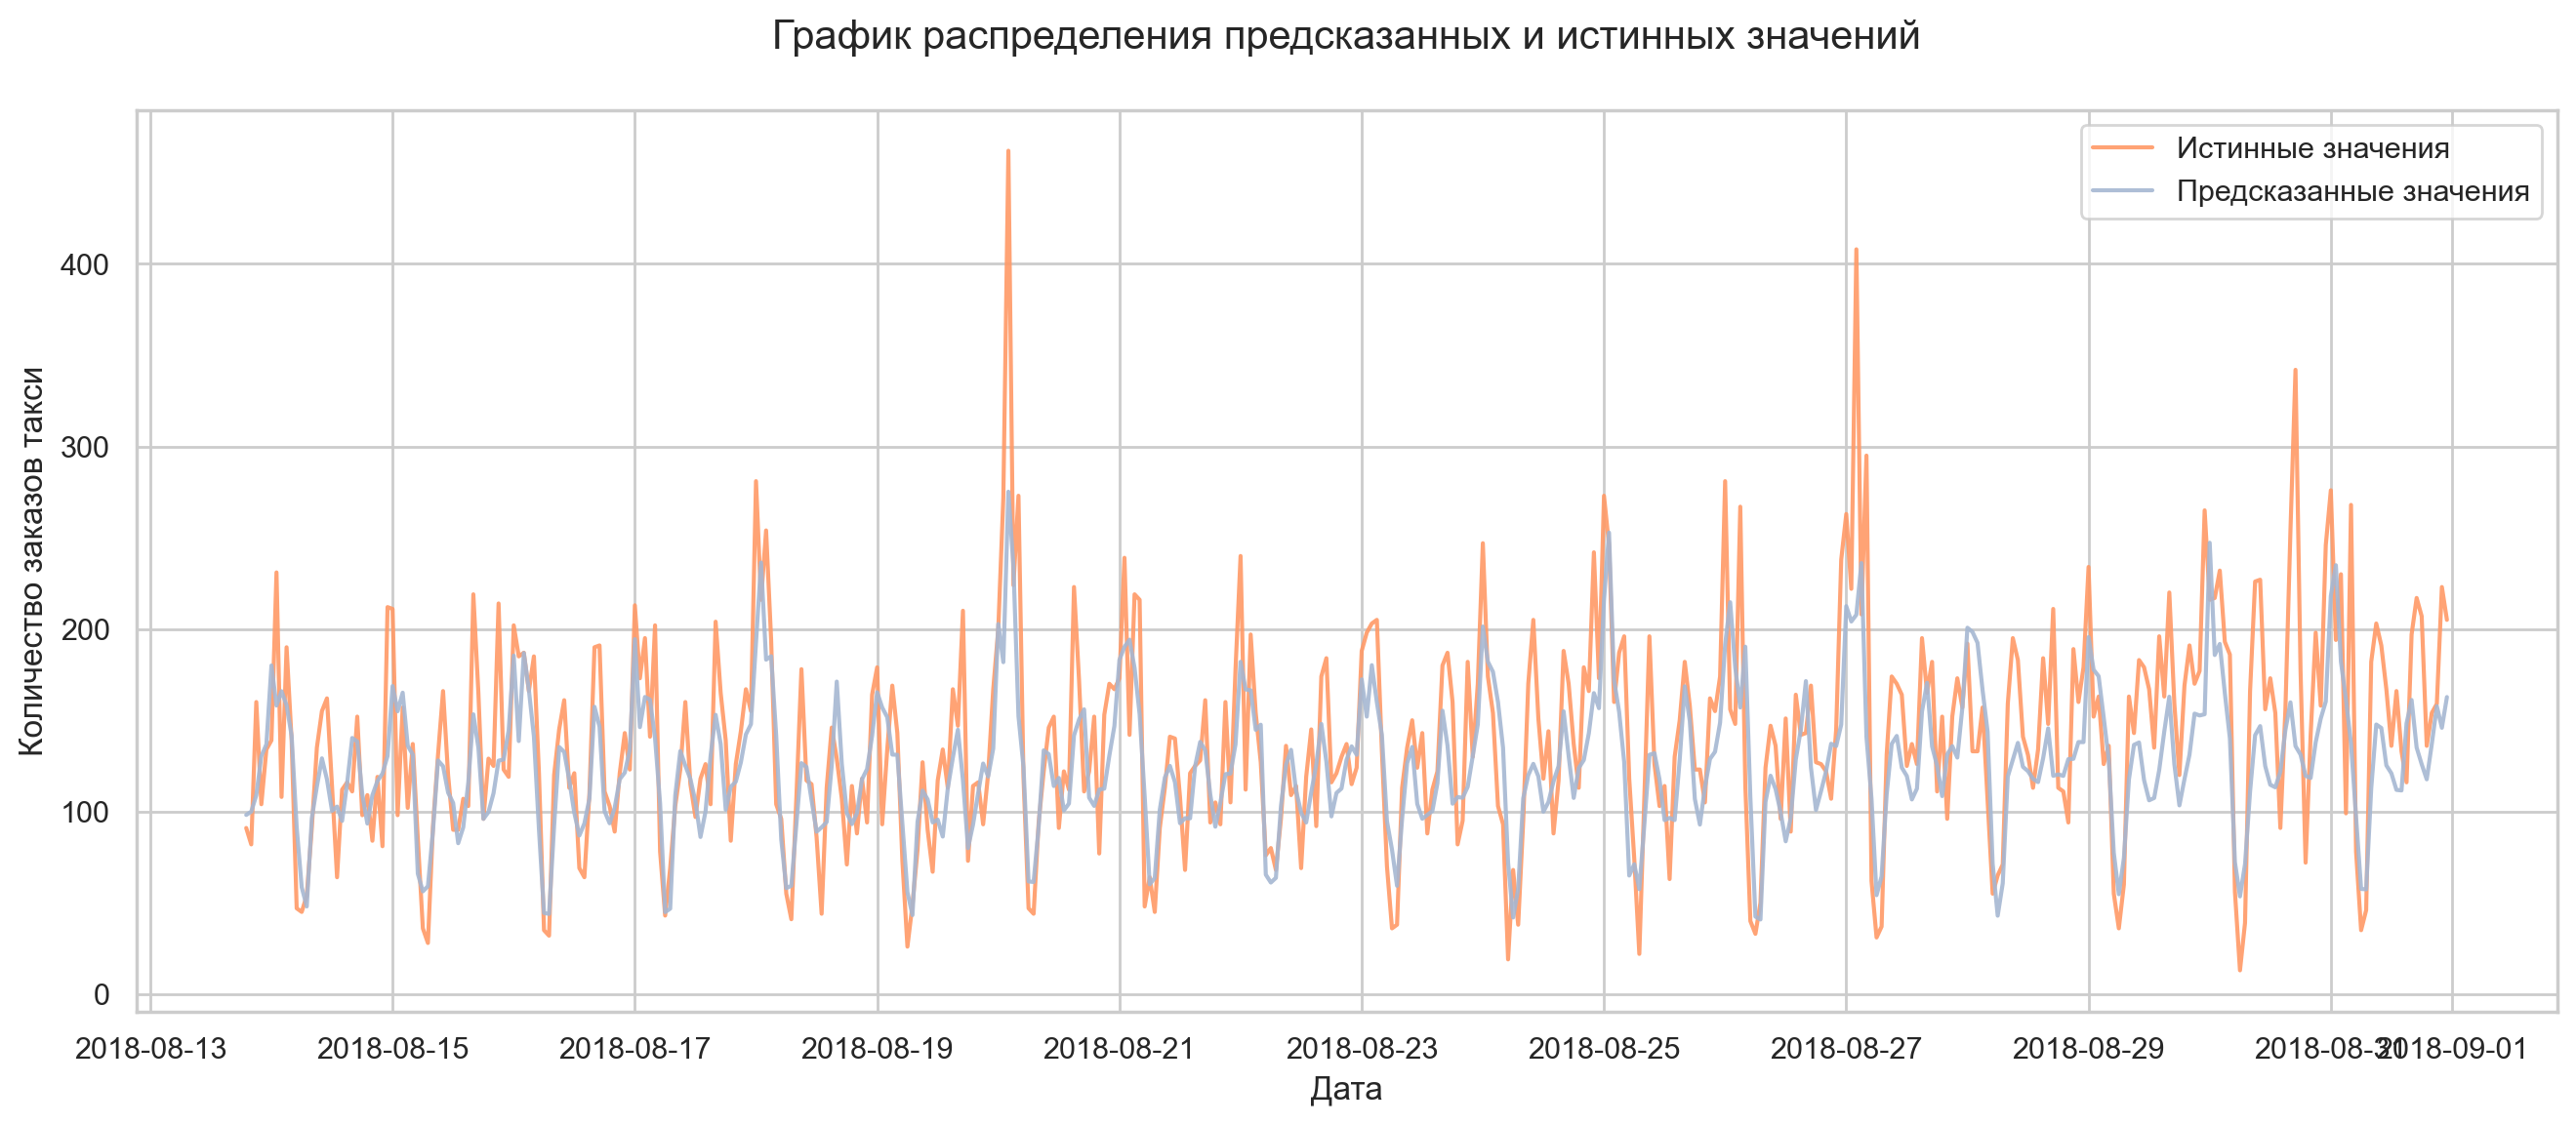

In [30]:
# построим график
plot_true_predict(target_test, predictions, '#A5B7D2', '#FF9966')

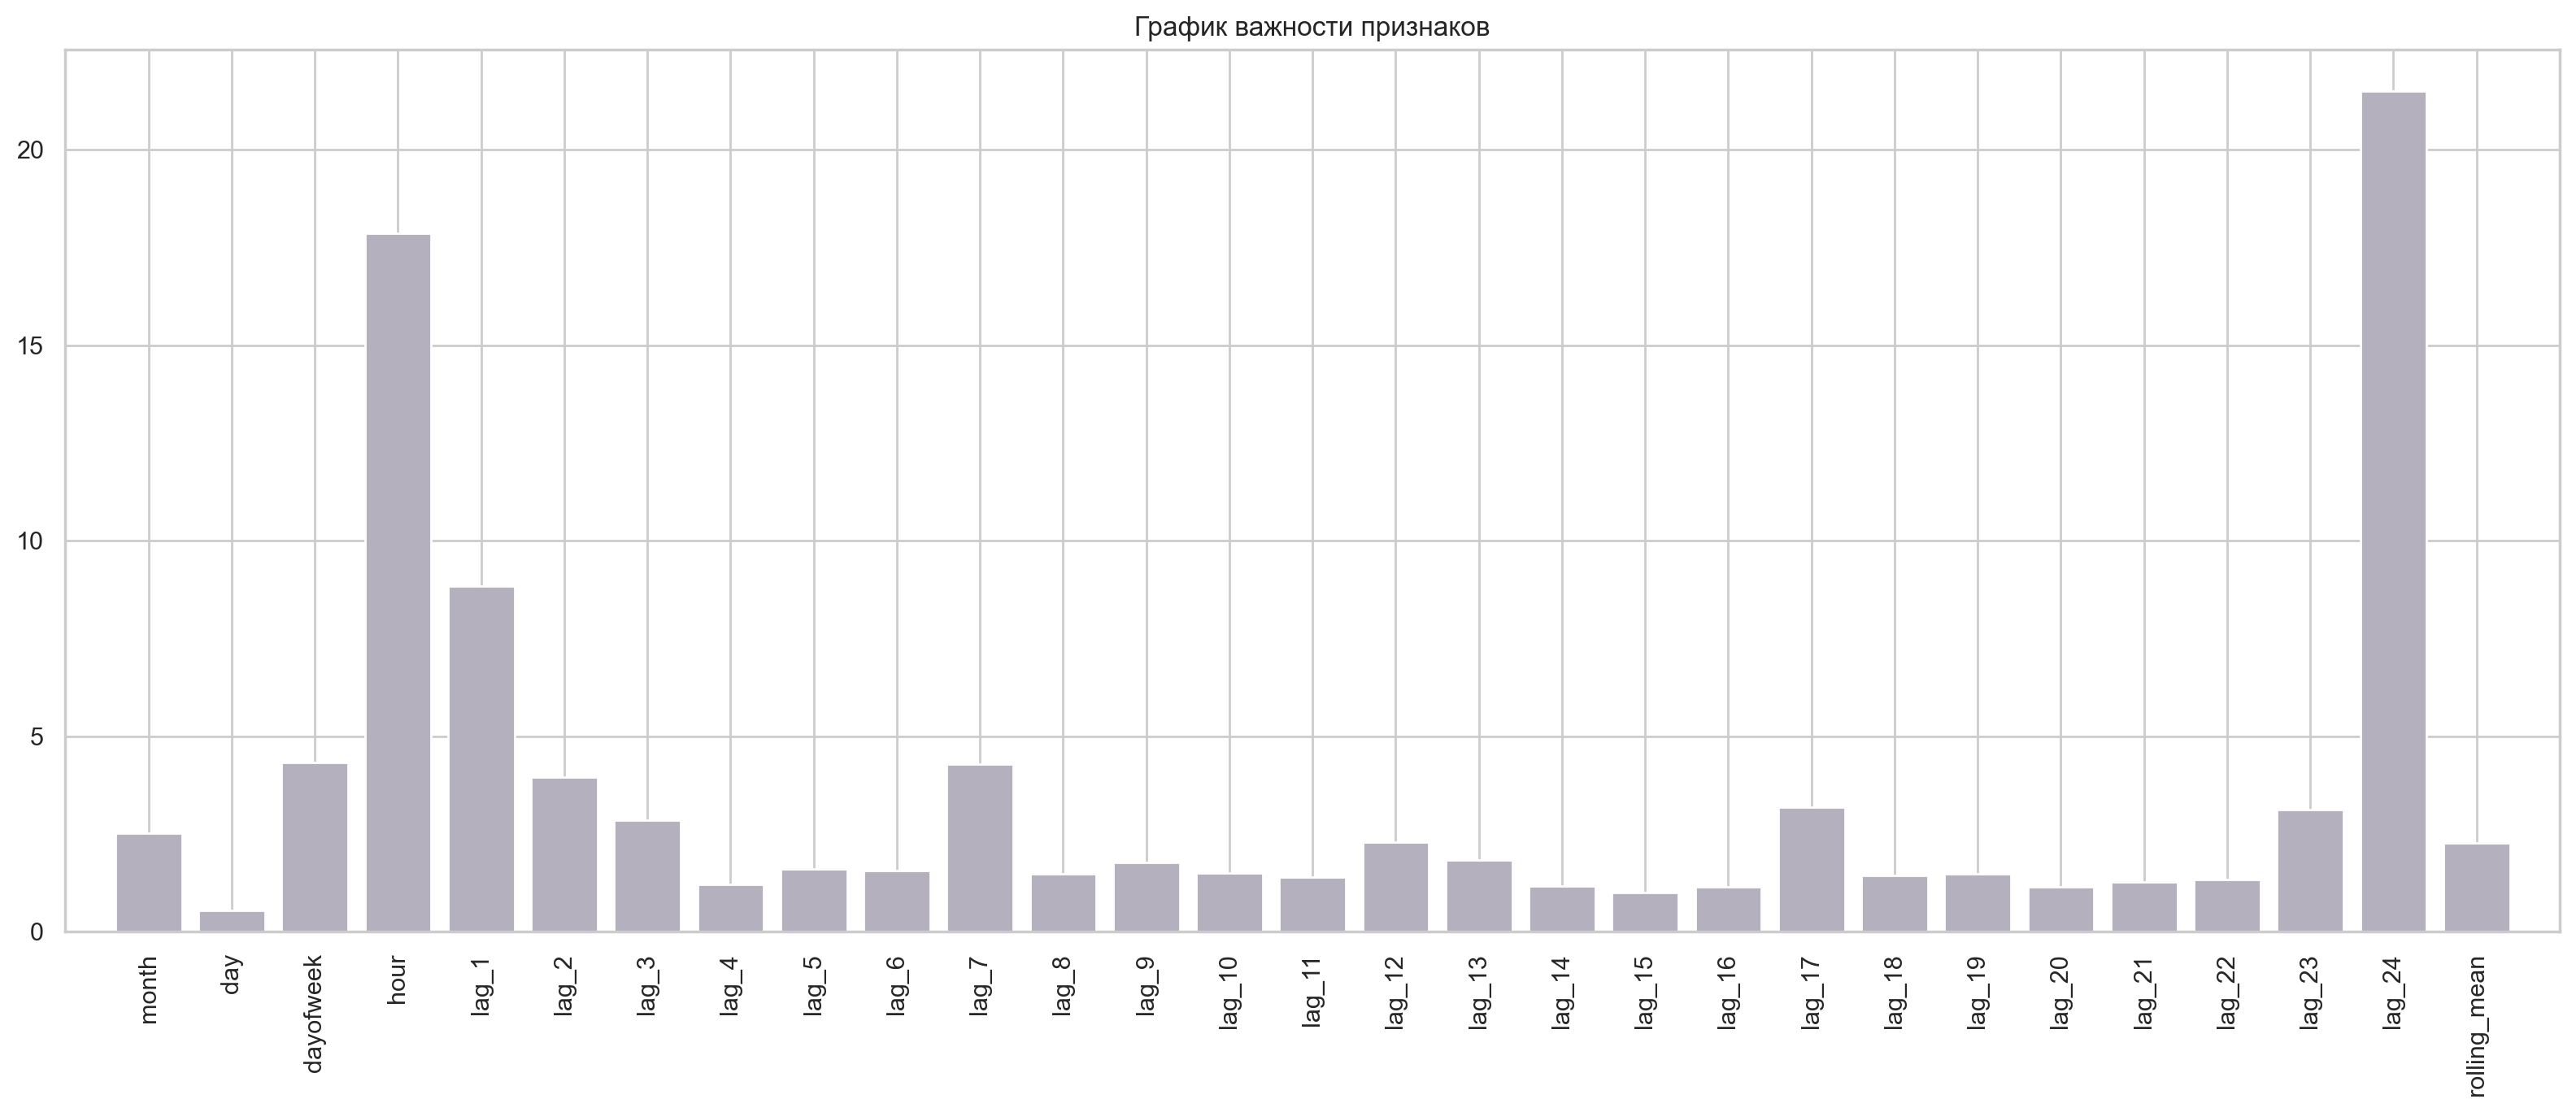

In [31]:
# определим, какие признаки вносят наибольший вклад в обучение модели
importances = list(model.feature_importances_)
columns = features_train.columns
not_null_importances = []
not_null_indices = []

for i in importances:
    if i > 0:
        not_null_importances.append(i)
        not_null_indices.append(columns[importances.index(i)])
    
plt.figure(figsize=(16, 7))
plt.title("График важности признаков")
 
plt.bar(range(len(not_null_importances)), not_null_importances, color="#B4B0BE")
plt.xticks(range(len(importances)), not_null_indices, rotation=90)
 
plt.tight_layout()
plt.xlim([-1, len(not_null_importances)])
plt.show()

**Вывод:**

- После тестирования модели финальный показатель RMSE = 41.1, что подходит под условия задачи. 

- Наибольший вклад в обучение модели вносят признаки: hour, lag24 и lag1.

### Проверка модели на адекватность

Создадим модель, где новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1). Определим RMSE такой модели. 

In [32]:
# запишем предыдущие значения ряда в отдельную переменную 
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:',  mean_squared_error(target_test, pred_previous, squared=False))

RMSE для проверки модели на адекватность: 59.01904048345839


**Вывод:**

- RMSE = 59 больше RMSE, полученном на тестовой выборке. Нашу модель можно считать адекватной.

### Вывод по шагу "Тестирование лучшей модели"

1. После тестирования модели градиентного бустинга на тестовой выборке финальный показатель RMSE = 39.8, что подходит под условия задачи.


2. Для проверки адекватности данного показателя было расчитано RMSE для модели, где новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1). Показатель оказался равным 59, следовательно, модель можно считать адекватной.

## Общий вывод

Цель настоящего исследования - подготовить прототип модели машинного обучения. Модель должна определять количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. В нашем распоряжении исторические данные о заказах такси в аэропортах. Для заказчика важно, чтобы значение метрики RMSE на тестовой выборке было не больше 48.


1. В нашем распоряжении были данные по количеству заказов такси с интервалом 10 минут с 1 марта 2018 года по 31 августа 2018 года. На первом этапе было проведено ресемплирование данных по одному часу, в итоге получился датафрейм на 4416 строк с целевым признаком "количество заказов".


2. За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа. Вероятно, это вызвано ростом компании, так как есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет. Помимо этого на графиках видна суточная сезонность. Ночью количество заказов стремится к нулю, а вечер - момент самого сильного спроса на услуги такси.

3. Перед обучением моделей в данные были добавлены новые показатели: месяц, день, день недели, час, фактор lag для определения интервала на котором обучается модель и скользящее среднее. Данные были разделены на обучающую и тестовую выборку в отношении 9:1.

4. В обучении модели участвовали четыре различных алгоритма: Линейная регрессия (Linear Regression), Случайный лес (Random Forest Regressor), Градиентный бустинг (Cat Boost Regressor) и Стохастический градиентный бустинг (Light GBM). У каждой модели менялись гиперпараметры, чтобы добиться наиболее высокой оценки качества. Оценкой качества модели была выбрана метрика RSME - среднеквадратичная ошибка, которая сообщает нам среднее расстояние между прогнозируемыми значениями из модели и фактическими значениями в наборе данных.

5. По итогам исследования был сделан вывод, что для определения количества заказов такси на следующий час наиболее подходящей моделью является модель, построенная на **алгоритме градиентного бустинга (Cat Boost Regressor) с количеством итераций 2000, максимальной глубиной дерева 6 и скоростью обучения 0.01**. Показатель RMSE такой модели после тестирования = 41.1.